In [1]:
%load_ext watermark
%watermark -a 'cs224' -u -d -v -p numpy,xarray,scipy,pandas,sklearn,matplotlib,seaborn,pymc3

cs224 
last updated: 2020-04-14 

CPython 3.6.10
IPython 7.13.0

numpy 1.18.1
xarray 0.15.0
scipy 1.4.1
pandas 1.0.2
sklearn 0.22.1
matplotlib 3.1.3
seaborn 0.10.0
pymc3 3.8


In [2]:
%matplotlib inline
import numpy as np, scipy, scipy.stats as stats, scipy.special, scipy.misc, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, xarray as xr
import matplotlib as mpl

import pymc3 as pm

import theano as thno
import theano.tensor as T

import sklearn, sklearn.linear_model

import datetime, time, math
from dateutil import relativedelta

from collections import OrderedDict

SEED = 42
np.random.seed(SEED)

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
np.set_printoptions(edgeitems=10)
np.set_printoptions(linewidth=1000)
np.set_printoptions(suppress=True)
np.core.arrayprint._line_width = 180

sns.set()
# sns.set_style("whitegrid")

In [3]:
from IPython.display import display, HTML

from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        if type(df) == np.ndarray:
            df = pd.DataFrame(df)
        html_str+=df.to_html()
    html_str = html_str.replace('table','table style="display:inline"')
    # print(html_str)
    display_html(html_str,raw=True)

CSS = """
.output {
    flex-direction: row;
}
"""

def display_graphs_side_by_side(*args):
    html_str='<table><tr>'
    for g in args:
        html_str += '<td>'
        html_str += g._repr_svg_()
        html_str += '</td>'
    html_str += '</tr></table>'
    display_html(html_str,raw=True)
    

display(HTML("<style>.container { width:70% !important; }</style>"))

In [4]:
%load_ext autoreload
%autoreload 1
%aimport covid19

Data Source: [CSSEGISandData/COVID-19](https://github.com/CSSEGISandData/COVID-19), the data behind the dashboard: [Coronavirus COVID-19 Global Cases by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University (JHU)](https://gisanddata.maps.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6).

It seems that there are currently [data-changes](https://github.com/CSSEGISandData/COVID-19/commit/0cea9b2179306618bd7917798819ebf6608d67de#comments) in progress that cause issues. This is mostly an issue for the US data, so that I comment it out. The US data as used in this notebook **is currently wrong**.

In [5]:
covid19.time_series_19_covid_confirmed.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,5,7,7,7,11,16,21,22,22,22,24,24,40,40,74,84,94,110,110,120,170,174,237,273,281,299,349,367,423,444,484,521,555,607,665
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,10,12,23,33,38,42,51,55,59,64,70,76,89,104,123,146,174,186,197,212,223,243,259,277,304,333,361,377,383,400,409,416,433,446,467
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,3,5,12,12,17,17,19,20,20,20,24,26,37,48,54,60,74,87,90,139,201,230,264,302,367,409,454,511,584,716,847,986,1171,1251,1320,1423,1468,1572,1666,1761,1825,1914,1983
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,39,39,53,75,88,113,133,164,188,224,267,308,334,370,376,390,428,439,466,501,525,545,564,583,601,601,638,646
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,3,3,3,4,4,5,7,7,7,8,8,8,10,14,16,17,19,19,19,19,19,19


In [6]:
covid19.time_series_19_covid_recovered.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,5,5,10,10,10,15,18,18,29,32,32,32,32,32
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,10,17,17,31,31,33,44,52,67,76,89,99,104,116,131,154,165,182,197,217,232
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,8,12,12,12,12,12,32,32,32,65,65,24,65,29,29,31,31,37,46,61,61,62,90,90,90,113,237,347,405,460,591,601
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,10,10,10,10,16,21,26,31,39,52,58,71,71,128,128
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,2,2,2,2,2,2,2,4,4,4


In [7]:
list(covid19.augment_time_series_from_daily_snapshots_date_range)

[]

In [8]:
# ldf = covid19.augment_time_series_from_daily_snapshots(covid19.augment_time_series_from_daily_snapshots_date_range)
# ldf

In [9]:
# ldf = covid19.augment_time_series_from_daily_snapshots(covid19.augment_time_series_from_daily_snapshots_date_range)[0][['Province/State', 'Country/Region', '3/15/20']]
# # # ldf[ldf['3/14/20'] < 0]
# ldf[ldf['Country/Region'] == 'Spain']

In [10]:
# ldf_confirmed, ldf_recovered, ldf_death, columns, selector = covid19.get_cases_by_region()

In [11]:
df = covid19.get_cases_by_region()
df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-04-09,112638,52407,2312,4445,8751,242
2020-04-10,117790,55980,2537,5152,3573,225
2020-04-11,121324,58190,2689,3534,2210,152
2020-04-12,124242,60260,2834,2918,2070,145
2020-04-13,126615,62925,2993,2373,2665,159


In [12]:
df = covid19.get_cases_by_region(region='China')
df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-04-09,82883,77679,3339,74,112,2
2020-04-10,82941,77791,3340,58,112,1
2020-04-11,83014,77877,3343,73,86,3
2020-04-12,83134,77956,3343,120,79,0
2020-04-13,83213,78039,3345,79,83,2


In [13]:
# df = covid19.get_cases_by_region(region='Switzerland')
# df

In [14]:
# df = covid19.get_cases_by_region(region='US')
# df

* [BAR CHART ANNOTATIONS WITH PANDAS AND MATPLOTLIB](https://robertmitchellv.com/blog-bar-chart-annotations-pandas-mpl.html)

In [15]:
cbr_germany = covid19.CasesByRegion('Germany')
cbr_germany.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-04-09,112638,52407,2312,4445,8751,242
2020-04-10,117790,55980,2537,5152,3573,225
2020-04-11,121324,58190,2689,3534,2210,152
2020-04-12,124242,60260,2834,2918,2070,145
2020-04-13,126615,62925,2993,2373,2665,159


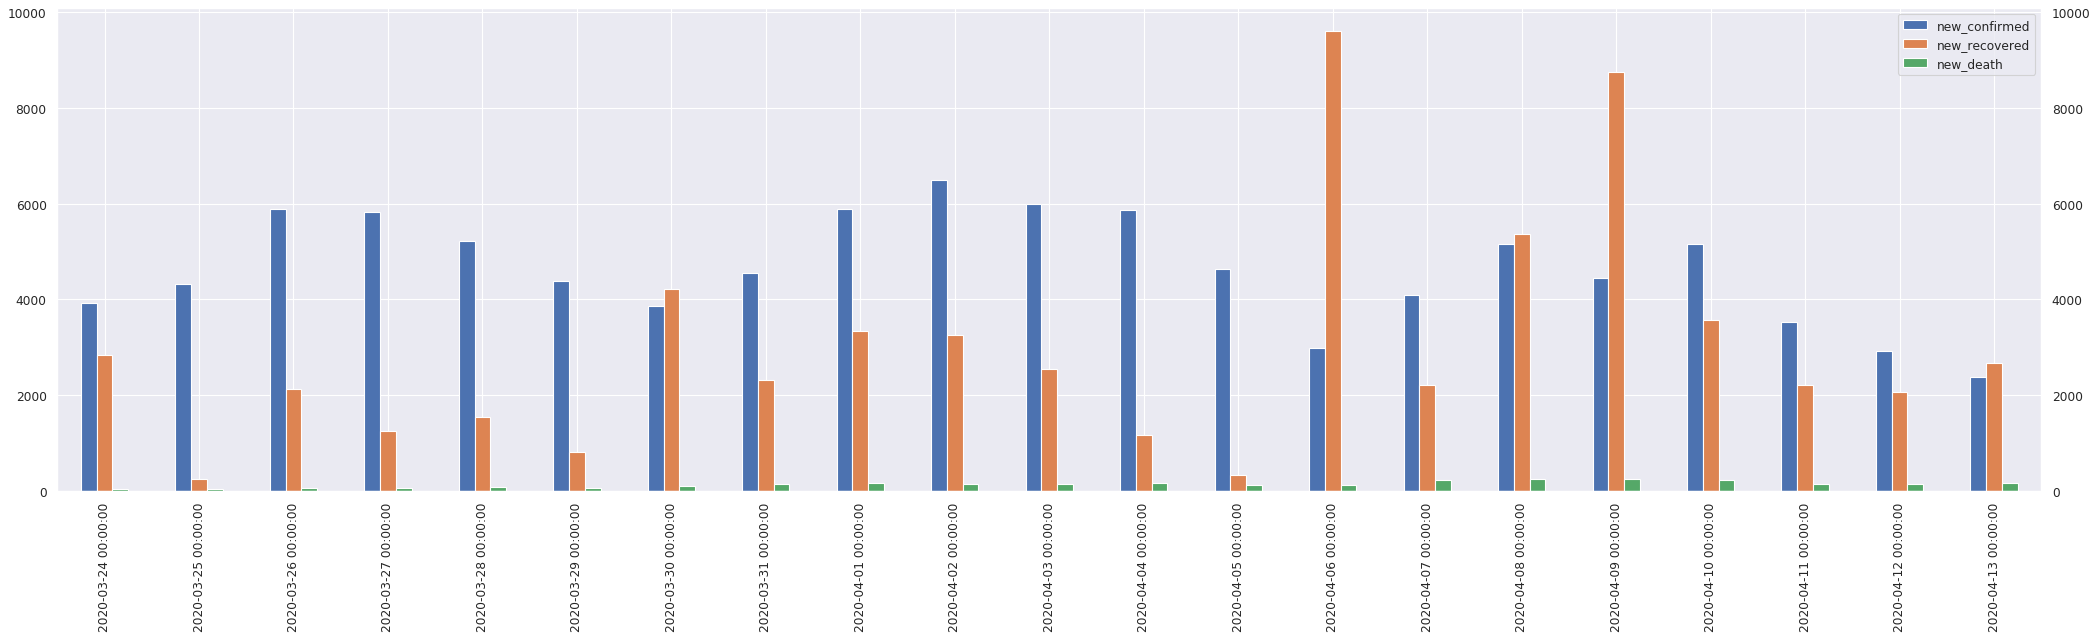

In [16]:
cbr_germany.plot_daily_stats()

135.0 184.0


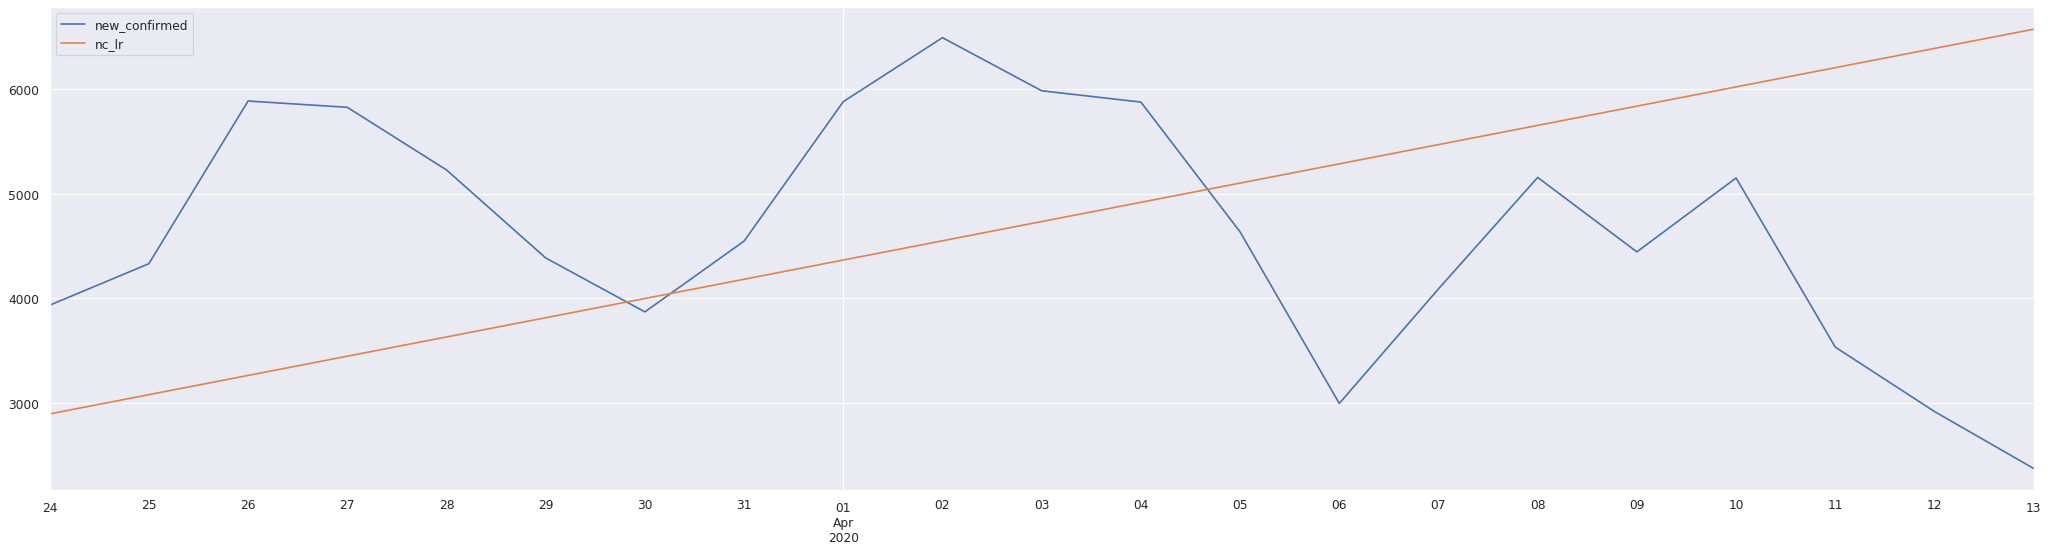

In [17]:
date_range = pd.date_range(pd.to_datetime('2020-03-09'),pd.to_datetime('2020-03-16'))
cbr_germany_new_confirmed_df = cbr_germany.df.loc[date_range,['new_confirmed']]
x = np.arange(len(cbr_germany_new_confirmed_df) * 1.0)

regressor = sklearn.linear_model.LinearRegression()  
regressor.fit(x.reshape(-1, 1), cbr_germany_new_confirmed_df.new_confirmed.values.reshape(-1, 1) * 1.0)

last_day = cbr_germany.df.index[-1]
ldr = pd.date_range(pd.to_datetime('2020-03-09'),pd.to_datetime(last_day))
x = np.arange(len(ldr) * 1.0)

y = regressor.intercept_[0] + regressor.coef_[0,0]*x
cbr_germany_new_confirmed_lr_df = pd.DataFrame(y.reshape(-1,1),index=ldr, columns=['nc_lr'])

ldf = pd.concat([cbr_germany.df, cbr_germany_new_confirmed_lr_df], axis=1)
ldf.loc[:] = ldf.values * 1.0
ldf = ldf.loc[last_day + datetime.timedelta(days=-20):,['new_confirmed', 'nc_lr']]
fig = plt.figure(figsize=(32, 8), dpi=80, facecolor='w', edgecolor='k')
ax  = plt.subplot(1, 1, 1)
ldf.plot(ax=ax)
print(regressor.intercept_[0].round(2), regressor.coef_[0,0].round(2))

[COVID-19-Pandemie#Deutschland](https://de.wikipedia.org/wiki/COVID-19-Pandemie#Deutschland):

> Am 22. März 2020 einigten sich Bund und Länder auf ein „umfassendes Kontaktverbot“, statt weitergehende Ausgangssperren zu beschließen.

| prediction date | predicted day for reaching 100 threshold | predicted max | growth rate  | steady state rate  |
| :--- | :--- | ---: | ---: | ---: |
| 2020-04-02 | 2020-04-21 |  92845 | 0.057 | - |
| 2020-04-03 | 2020-04-23 |  99774 | 0.054 | - |
| 2020-04-04 | 2020-04-25 | 107193 | 0.051 | - |
| 2020-04-05 | 2020-04-27 | 114511 | 0.049 | - |
| 2020-04-06 | 2020-04-29 | 119618 | 0.045 | - |
| 2020-04-07 | 2020-04-29 | 121354 | 0.039 | - |
| 2020-04-08 | 2020-04-30 | 123011 | 0.035 | - |
| 2020-04-09 | 2020-04-30 | 125833 | 0.031 | - |
| 2020-04-10 | - | - | 0.049 | 4820 |
| 2020-04-11 | - | - | 0.042 | 4739 |
| 2020-04-12 | - | - | 0.040 | 4570 |
| 2020-04-13 | - | - | 0.036 | 4300 |
| 2020-04-14 | - | - | 0.033 | 3927 |

sigmoid+linear 2020-05-22 00:00:00 [57623.11197094     0.21725668    -3.84466147 18075.61813073] 0.03286821743621271 3927.048803989652


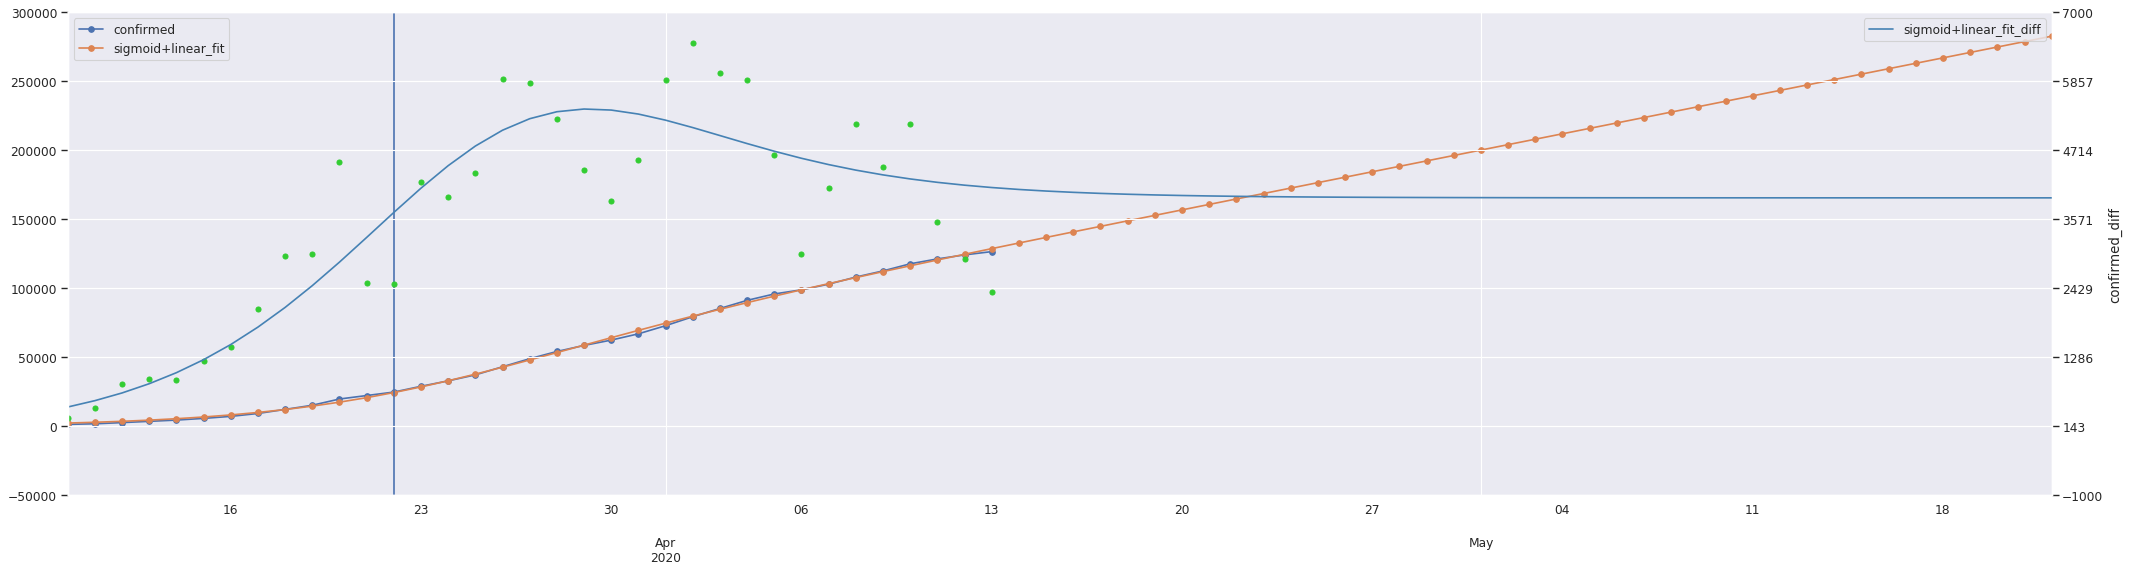

In [18]:
country_name, first_date, init_add, restriction_start_date = 'Germany', pd.to_datetime('2020-03-09'), 0, datetime.datetime(2020, 3, 22)
ldf, lpopt, lpcov, lsqdiff, lgrowthRate, idx, label = covid19.prepare_country_prediction(country_name, first_date=first_date, init_add=init_add)
if len(lpopt) == 4:
    steady_state_rate = lpopt[1] * lpopt[3]
else:
    steady_state_rate = 0.0
print(label, ldf.index[-1], lpopt, lgrowthRate, steady_state_rate)
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
ldf[['confirmed', label + '_fit']].iloc[1:,:].plot(ax=ax, marker=mpl.path.Path.unit_circle(), markersize=5);
ax.axvline(restriction_start_date);

ax2 = ax.twinx()
ldf[[label + '_fit_diff']].iloc[1:,:].plot(ax=ax2, color=['steelblue']);
lbl = 'confirmed' + '_diff'
ldf[[lbl]].iloc[1:,:].reset_index().plot.scatter(ax=ax2, x = 'index', y = lbl, c='limegreen')


l = len(ax.get_yticks())
a1 = ax.get_yticks()[0]
e1 = ax.get_yticks()[-1]
a2 = ax2.get_yticks()[0]
e2 = ax2.get_yticks()[-1]
ax.set_yticks(np.linspace(a1, e1, l));
ax2.set_yticks(np.linspace(a2, e2, l));

In [19]:
ldf[[label + '_fit_diff']].apply(['max'])

,sigmoid+linear_fit_diff
max,5397.611335


In [20]:
lds = ldf['confirmed']
idx = lds.index.get_loc(lds.last_valid_index())
lds.iloc[idx] - lds.iloc[idx-1]

2373.0

sigmoid+linear 2020-05-21 00:00:00 [70629.43315749     1.48370961    -3.96584081 16035.7513348 ] 0.2998631420995981 23792.398420702382 0.03817625111154843 3398.9140601003405


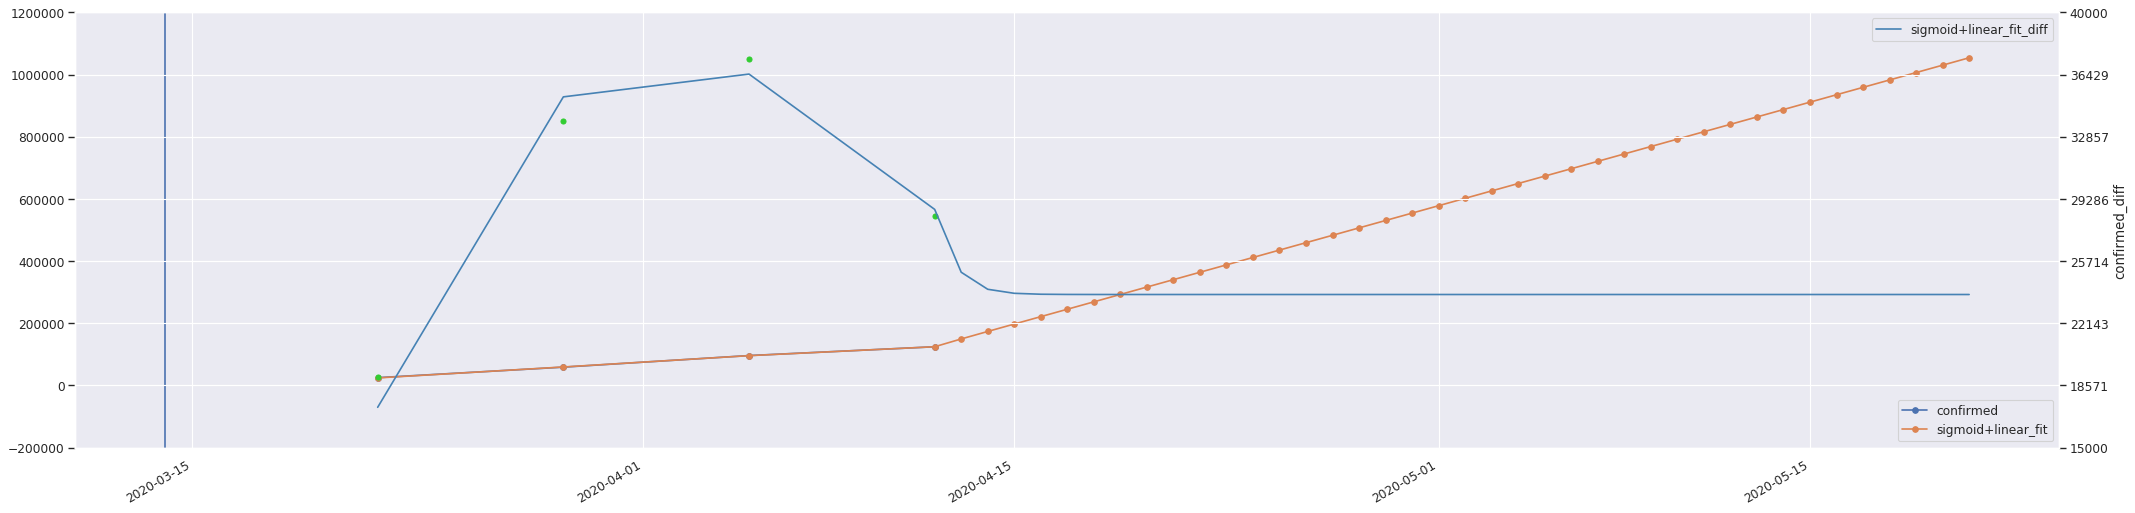

In [72]:
last_date_for_week_aggregation = cbr_germany.df.index[-1] + relativedelta.relativedelta(weekday=relativedelta.SU(-1))
ldf = cbr_germany.df[(cbr_germany.df.index >= first_date) & (cbr_germany.df.index <= last_date_for_week_aggregation)][['confirmed']]
in_df = ldf.resample('W').agg(pd.Series.max, skipna=False) #.sum(skipna=False) # 

ldf, lpopt, lpcov, lsqdiff, lgrowthRate, idx, label = covid19.prepare_country_prediction(country_name, first_date=first_date, init_add=init_add, in_df=in_df)
if len(lpopt) == 4:
    steady_state_rate = lpopt[1] * lpopt[3]
else:
    steady_state_rate = 0.0
print(label, ldf.index[-1], lpopt, lgrowthRate, steady_state_rate, np.power(1.0 + lgrowthRate,1/7) - 1.0, steady_state_rate / 7)
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
ldf[['confirmed', label + '_fit']].iloc[1:,:].plot(ax=ax, marker=mpl.path.Path.unit_circle(), markersize=5);
ax.axvline(restriction_start_date);

ax2 = ax.twinx()
ldf[[label + '_fit_diff']].iloc[1:,:].plot(ax=ax2, color=['steelblue']);
lbl = 'confirmed' + '_diff'
ldf[[lbl]].iloc[1:,:].reset_index().plot.scatter(ax=ax2, x = 'index', y = lbl, c='limegreen')


l = len(ax.get_yticks())
a1 = ax.get_yticks()[0]
e1 = ax.get_yticks()[-1]
a2 = ax2.get_yticks()[0]
e2 = ax2.get_yticks()[-1]
ax.set_yticks(np.linspace(a1, e1, l));
ax2.set_yticks(np.linspace(a2, e2, l));

In [22]:
# ldf.round(2)

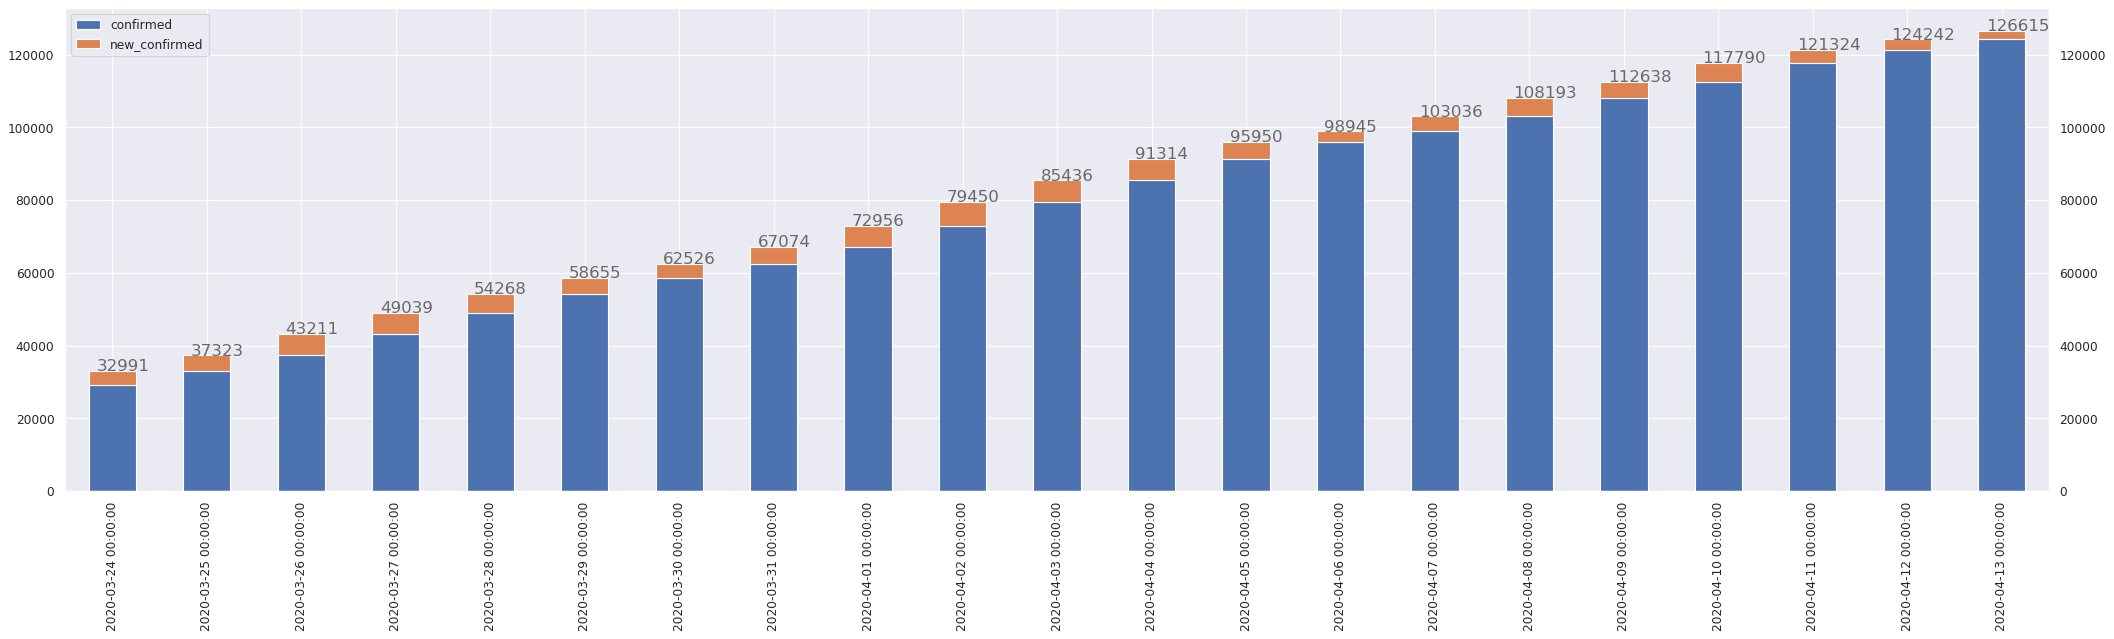

In [23]:
cbr_germany.plot_daily_stacked()

In [24]:
cbr_austria = covid19.CasesByRegion('Austria')
cbr_austria.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-04-09,13350,5240,295,274,728,22
2020-04-10,13652,6064,319,302,824,24
2020-04-11,13898,6604,337,246,540,18
2020-04-12,14006,7343,368,108,739,31
2020-04-13,14085,7633,384,79,290,16


[COVID-19-Pandemie#%C3%96sterreich](https://de.wikipedia.org/wiki/COVID-19-Pandemie#%C3%96sterreich)

> Nachdem Mitte März zuerst einzelne Gemeinden unter Quarantäne gestellt wurden, verlautbarte Bundeskanzler Sebastian Kurz am 15. März eine landesweite Ausgangsbeschränkung, verbunden mit einer Einschränkung der Versammlungsfreiheit auf bis zu fünf Personen.

`2020-03-15`

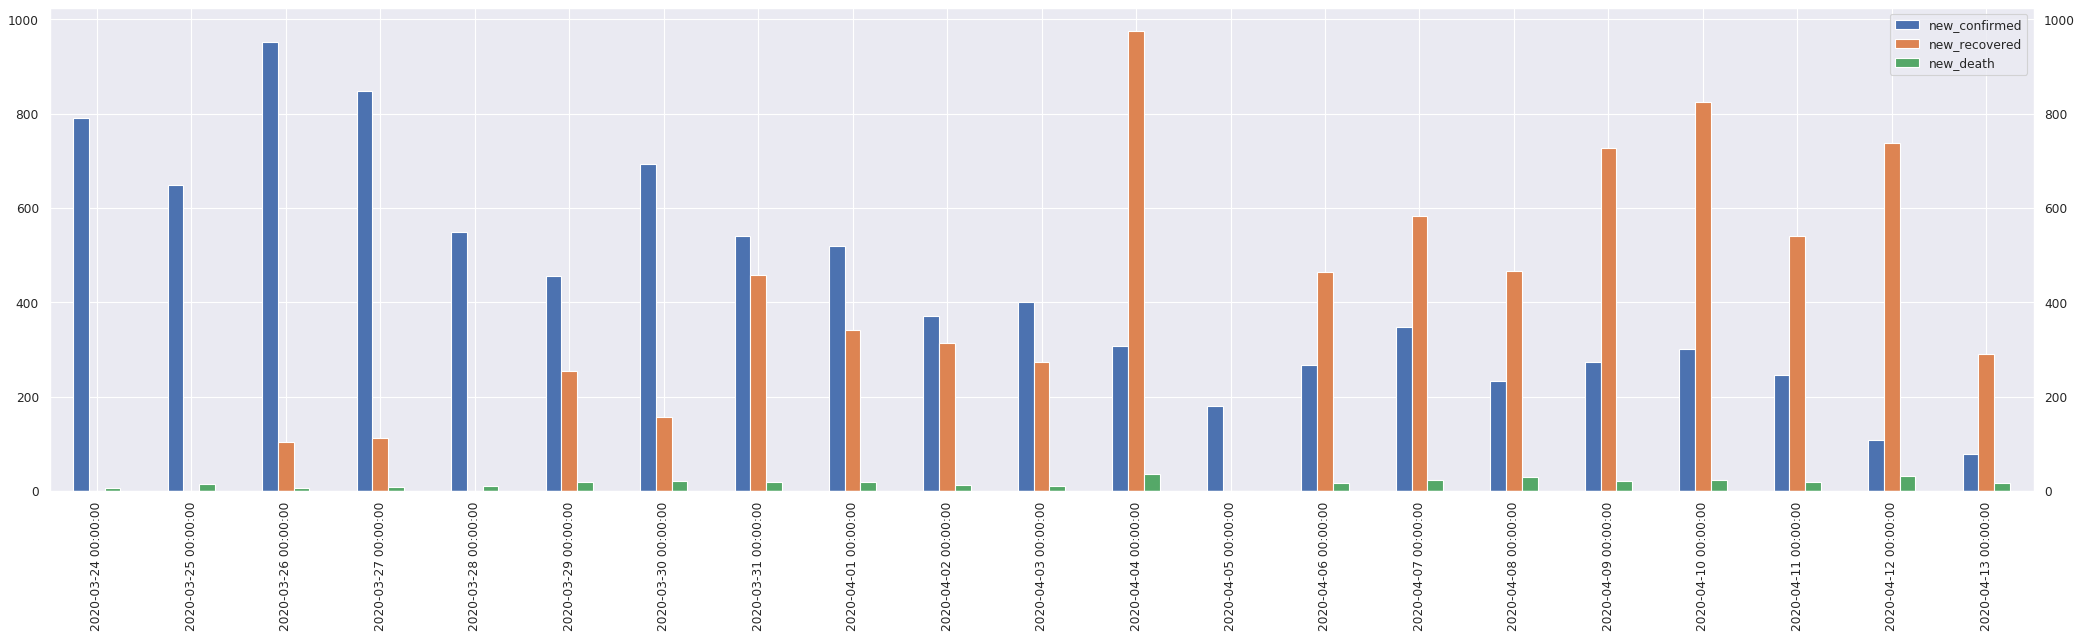

In [25]:
cbr_austria.plot_daily_stats()

| prediction date | predicted day for reaching 100 threshold | predicted max | growth rate | steady state rate  |
| :--- | :--- | ---: | ---: | ---: |
| 2020-04-02 | 2020-04-12 | 13859 | 0.042 | - |
| 2020-04-03 | 2020-04-12 | 13864 | 0.036 | - |
| 2020-04-04 | 2020-04-12 | 14082 | 0.030 | - |
| 2020-04-05 | 2020-04-12 | 13978 | 0.025 | - |
| 2020-04-06 | 2020-04-11 | 13947 | 0.020 | - |
| 2020-04-07 | 2020-04-12 | 14033 | 0.017 | - |
| 2020-04-08 | 2020-04-12 | 14121 | 0.014 | - |
| 2020-04-09 | 2020-04-12 | 14229 | 0.012 | - |
| 2020-04-10 | 2020-04-12 | 14350 | 0.010 | - |
| 2020-04-11 | 2020-04-13 | 14488 | 0.009 | - |
| 2020-04-12 | - | - | 0.012 | 106 |
| 2020-04-13 | - | - | 0.012 | 123 |
| 2020-04-14 | - | - | 0.011 | 126 |

sigmoid+linear 2020-05-22 00:00:00 [12377.9056918      0.21512237    -2.85685281   587.52228414] 0.011402312197499764 126.38918463773149


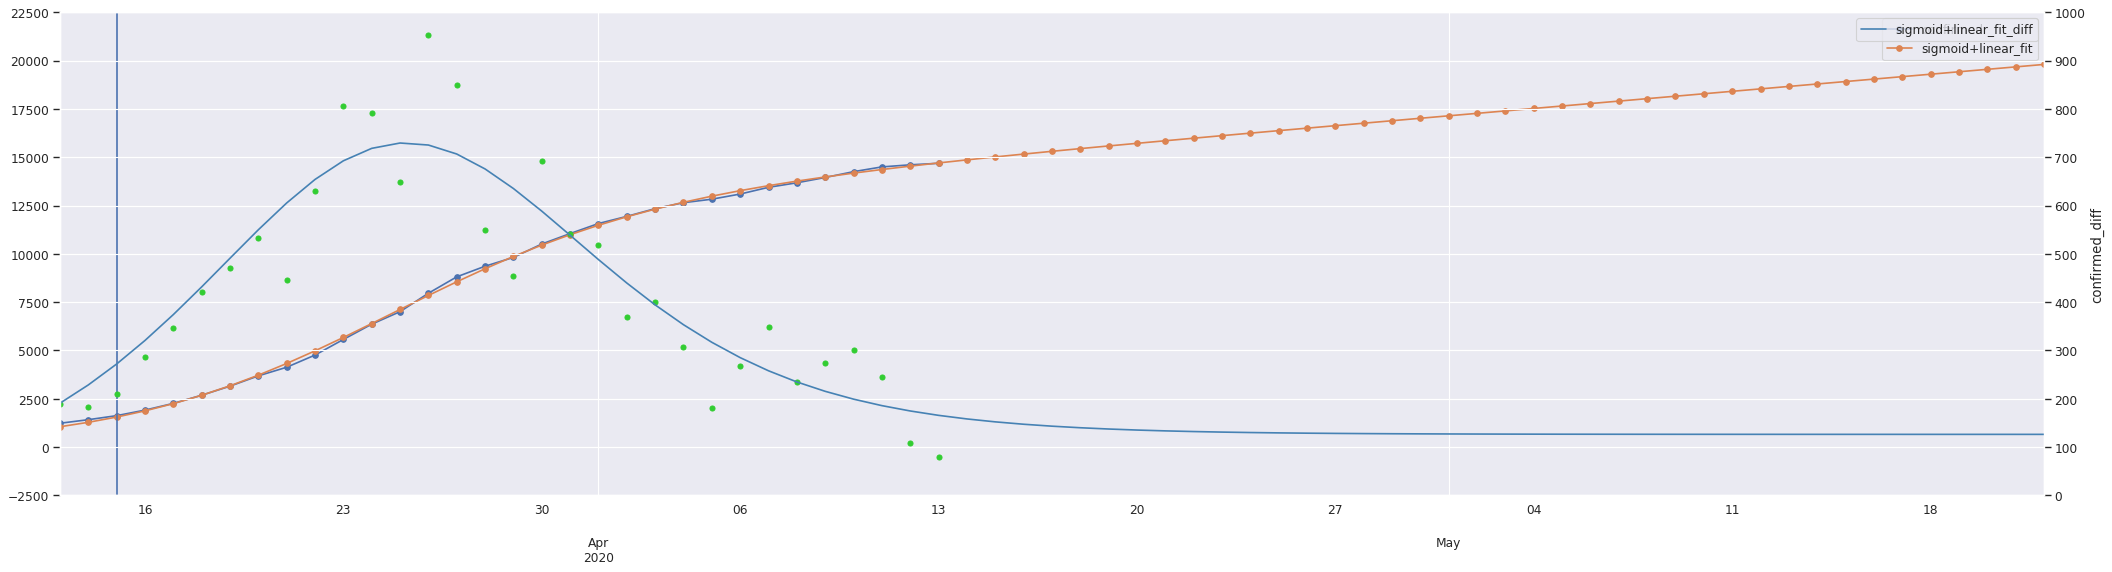

In [26]:
# country_name, first_date, init_add, restriction_start_date = 'Austria', pd.to_datetime('2020-02-19'), 600, datetime.datetime(2020, 3, 15)
country_name, first_date, init_add, restriction_start_date = 'Austria', pd.to_datetime('2020-03-12'), 600, datetime.datetime(2020, 3, 15)
ldf, lpopt, lpcov, lsqdiff, lgrowthRate, idx, label = covid19.prepare_country_prediction(country_name, first_date=first_date, init_add=init_add)
if len(lpopt) == 4:
    steady_state_rate = lpopt[1] * lpopt[3]
else:
    steady_state_rate = 0.0
print(label, ldf.index[-1], lpopt, lgrowthRate, steady_state_rate)
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
ldf[['confirmed', label + '_fit']].plot(ax=ax, marker=mpl.path.Path.unit_circle(), markersize=5);
ax.axvline(restriction_start_date);

ax2 = ax.twinx()
ldf[[label + '_fit_diff']].iloc[1:,:].plot(ax=ax2, color=['steelblue']);
lbl = 'confirmed' + '_diff'
ldf[[lbl]].iloc[1:,:].reset_index().plot.scatter(ax=ax2, x = 'index', y = lbl, c='limegreen')

l = len(ax.get_yticks())
a1 = ax.get_yticks()[0]
e1 = ax.get_yticks()[-1]
a2 = ax2.get_yticks()[0]
e2 = ax2.get_yticks()[-1]
ax.set_yticks(np.linspace(a1, e1, l));
ax2.set_yticks(np.linspace(0.0, e2, l));

In [28]:
ldf[[label + '_fit_diff']].apply(['max'])

,sigmoid+linear_fit_diff
max,729.366679


In [29]:
lds = ldf['confirmed']
idx = lds.index.get_loc(lds.last_valid_index())
lds.iloc[idx] - lds.iloc[idx-1]

79.0

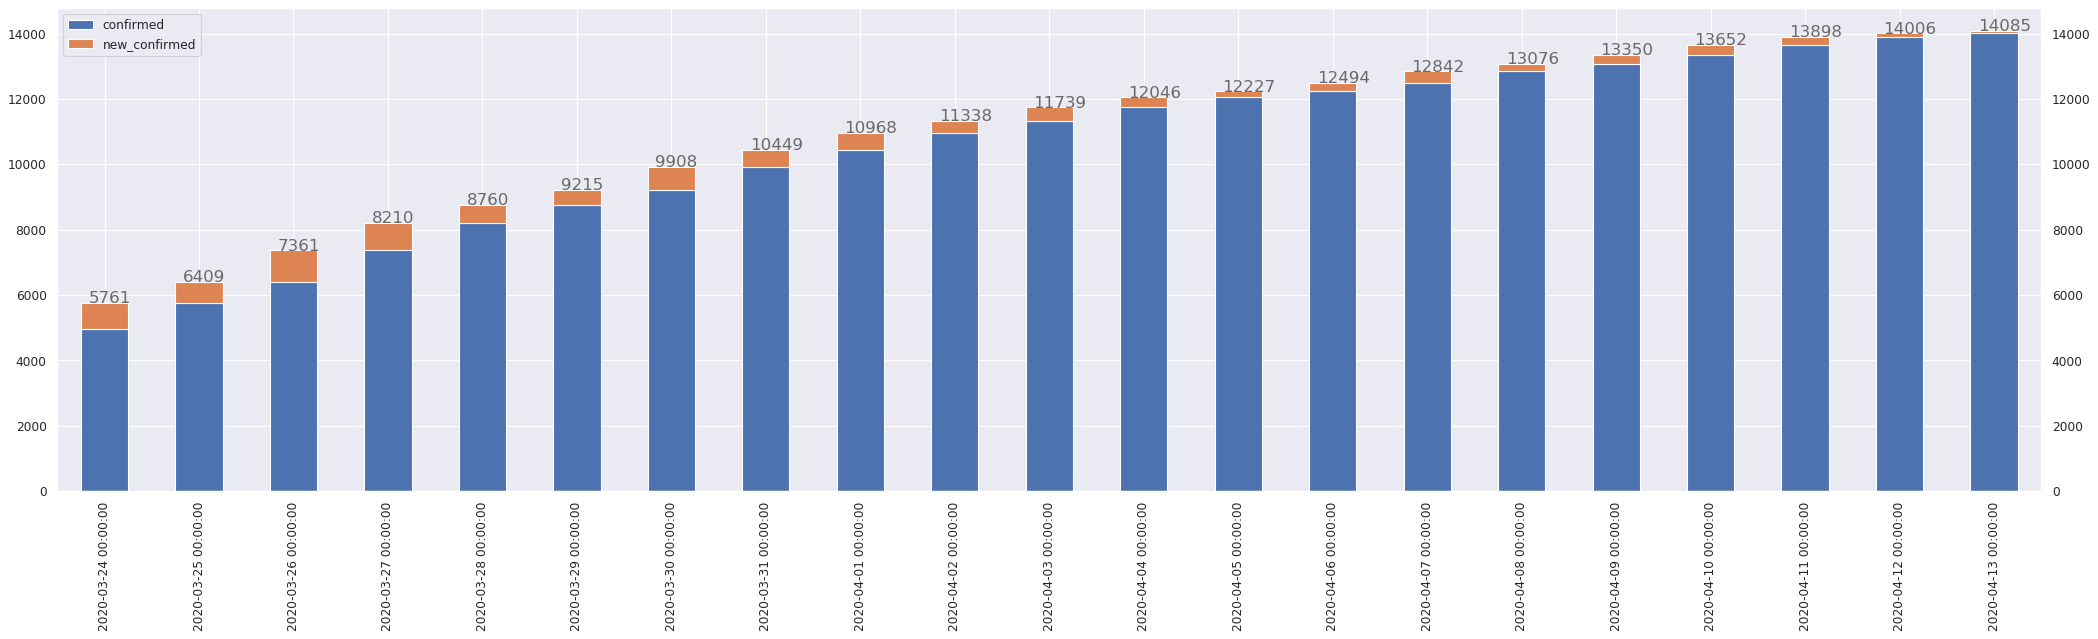

In [30]:
cbr_austria.plot_daily_stacked()

[COVID-19-Pandemie#Dänemark](https://de.wikipedia.org/wiki/COVID-19-Pandemie#D%C3%A4nemark)

> Dänemark hat besonders früh mit strikten Maßnahmen auf die Corona-Krise reagiert, unter anderem sind seit dem 14. März die Grenzen für Ausländer ohne triftigen Einreisegrund geschlossen.

`2020-03-14`

sigmoid 2020-05-01 00:00:00 [10645.27945815     0.10859213    -3.35426427] 0.04183306049794089 0.0


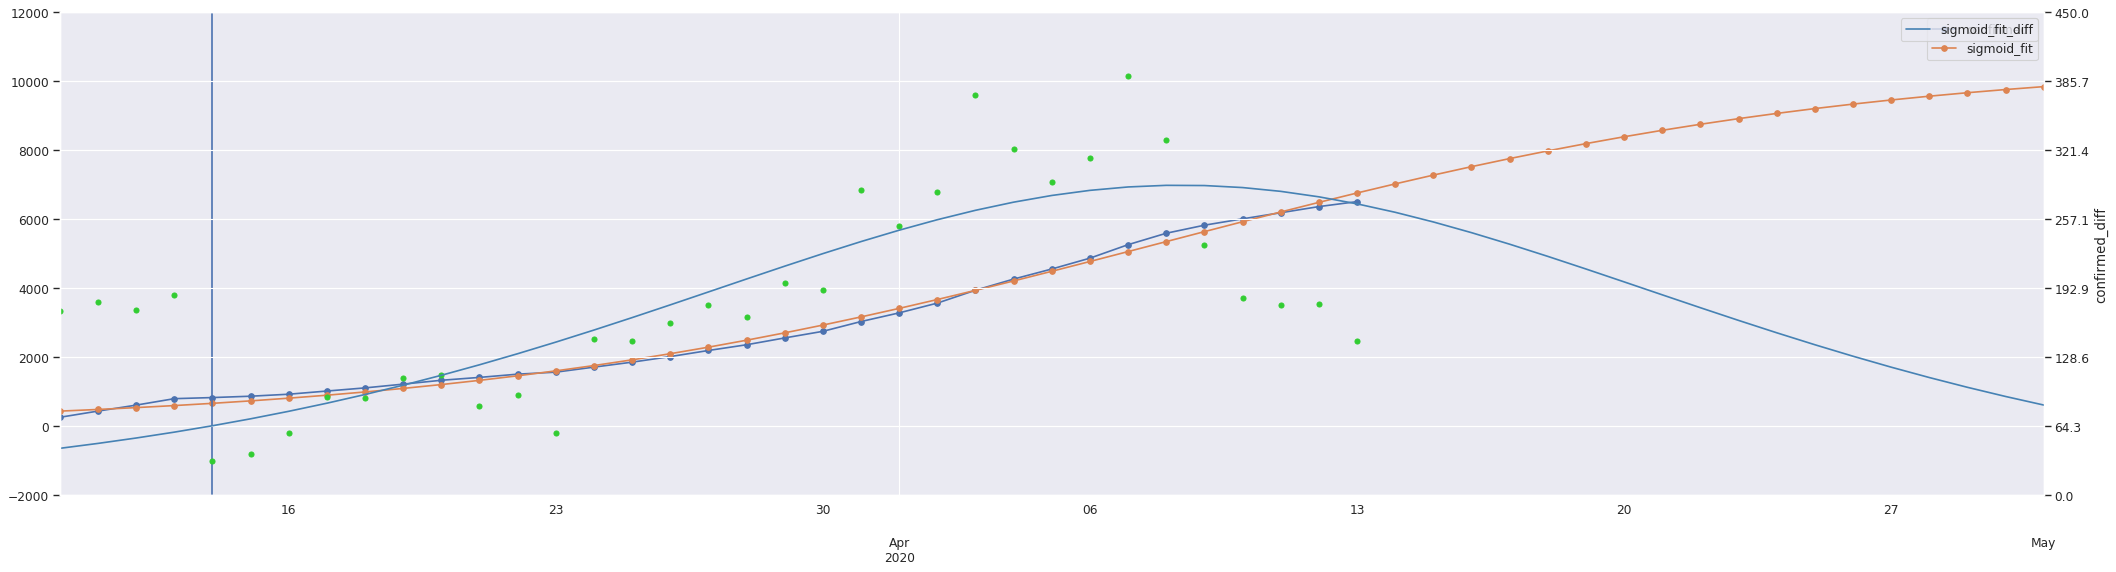

In [31]:
country_name, first_date, init_add, restriction_start_date = 'Denmark', pd.to_datetime('2020-03-09'), 0, datetime.datetime(2020, 3, 14)
ldf, lpopt, lpcov, lsqdiff, lgrowthRate, idx, label = covid19.prepare_country_prediction(country_name, first_date=first_date, init_add=init_add)
if len(lpopt) == 4:
    steady_state_rate = lpopt[1] * lpopt[3]
else:
    steady_state_rate = 0.0
print(label, ldf.index[-1], lpopt, lgrowthRate, steady_state_rate)
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
ldf[['confirmed', label + '_fit']].plot(ax=ax, marker=mpl.path.Path.unit_circle(), markersize=5);
ax.axvline(restriction_start_date);

ax2 = ax.twinx()
ldf[[label + '_fit_diff']].iloc[1:,:].plot(ax=ax2, color=['steelblue']);
lbl = 'confirmed' + '_diff'
ldf[[lbl]].iloc[1:,:].reset_index().plot.scatter(ax=ax2, x = 'index', y = lbl, c='limegreen')

l = len(ax.get_yticks())
a1 = ax.get_yticks()[0]
e1 = ax.get_yticks()[-1]
a2 = ax2.get_yticks()[0]
e2 = ax2.get_yticks()[-1]
ax.set_yticks(np.linspace(a1, e1, l));
ax2.set_yticks(np.linspace(0.0, e2, l));

In [32]:
ldf[[label + '_fit_diff']].apply(['max'])

,sigmoid_fit_diff
max,288.798887


There are several data issues since 2020-03-12/2020-03-13 in the input data as pointed out here: [Italy has the same number of cases today as they did yesterday.](https://github.com/CSSEGISandData/COVID-19/issues/599)

Also trying to get the raw numbers that [Coronavirus-Monitor](https://interaktiv.morgenpost.de/corona-virus-karte-infektionen-deutschland-weltweit/?fbclid=IwAR04HlqzakGaNssQzbz4d8o8R3gz0C910U8tvfYlBT6P0lVJJvHfk9uS2rc) is using for Germany from [@datentaeterin](https://twitter.com/datentaeterin/status/1237807179815686144). These numbers seem to be more up-to-date than all the other data-sources.

In [33]:
fname = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv'
alternative_italy_data = pd.read_csv(fname)
dates = pd.to_datetime(alternative_italy_data['data']).dt.date
alternative_italy_data = alternative_italy_data.rename(columns={"totale_casi": "confirmed", "deceduti": "death", "dimessi_guariti": "recovered"})
alternative_italy_data = alternative_italy_data[['confirmed', 'recovered', 'death']].copy()
for property in ['confirmed', 'recovered', 'death']:
    diff = alternative_italy_data[property].values[1:] - alternative_italy_data[property].values[:-1]
    alternative_italy_data['new_' + property] = np.concatenate([np.array([0]), diff])  
alternative_italy_data.index = dates
alternative_italy_data.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
data,,,,,,
2020-04-09,143626,28470,18279,4204,1979,610
2020-04-10,147577,30455,18849,3951,1985,570
2020-04-11,152271,32534,19468,4694,2079,619
2020-04-12,156363,34211,19899,4092,1677,431
2020-04-13,159516,35435,20465,3153,1224,566


In [34]:
cbr_italy = covid19.CasesByRegion('Italy', df=alternative_italy_data)
cbr_italy.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
data,,,,,,
2020-04-09,143626,28470,18279,4204,1979,610
2020-04-10,147577,30455,18849,3951,1985,570
2020-04-11,152271,32534,19468,4694,2079,619
2020-04-12,156363,34211,19899,4092,1677,431
2020-04-13,159516,35435,20465,3153,1224,566


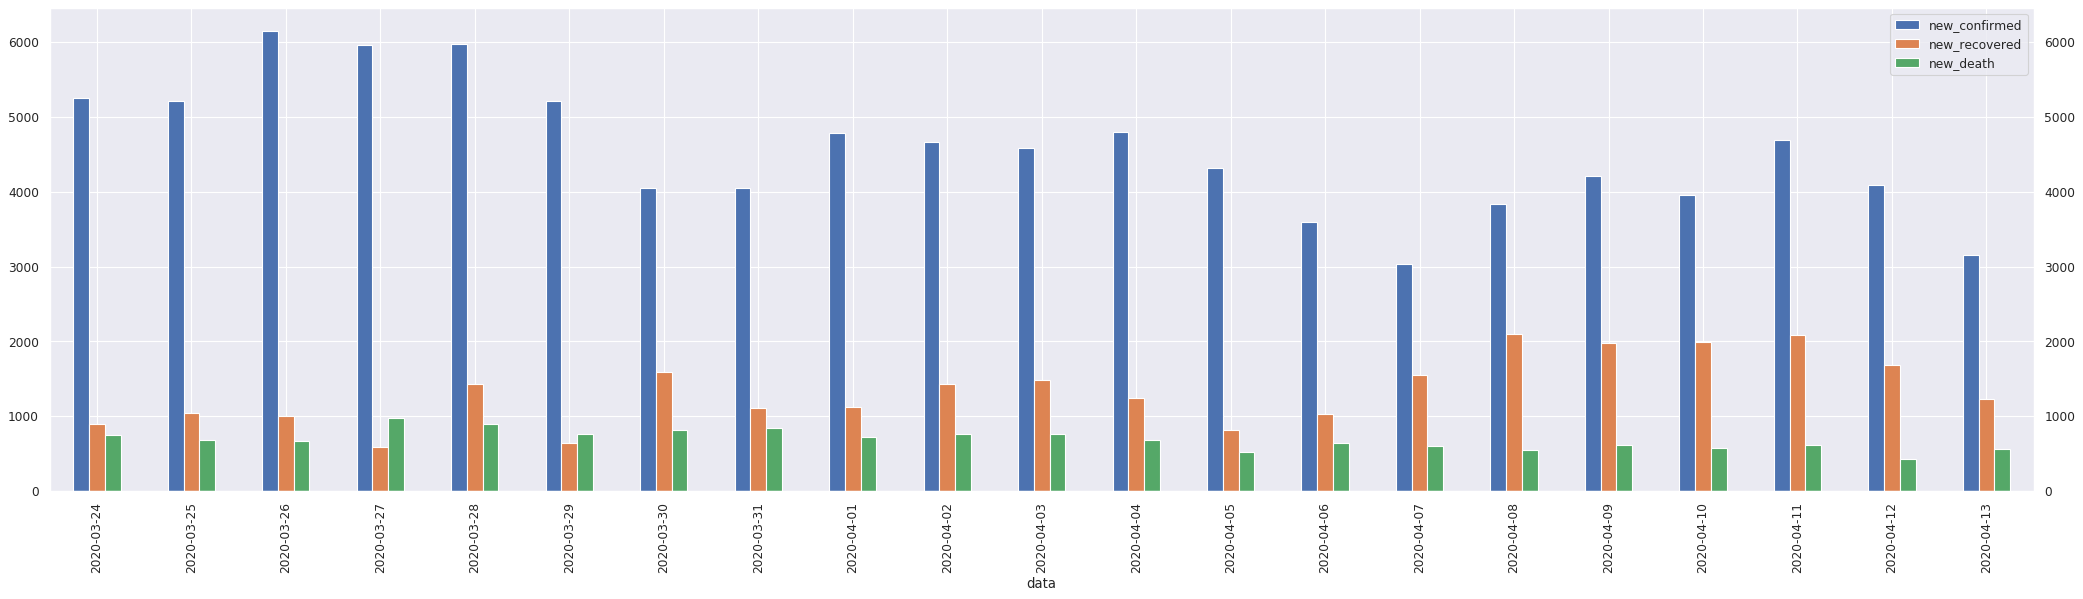

In [35]:
cbr_italy.plot_daily_stats()

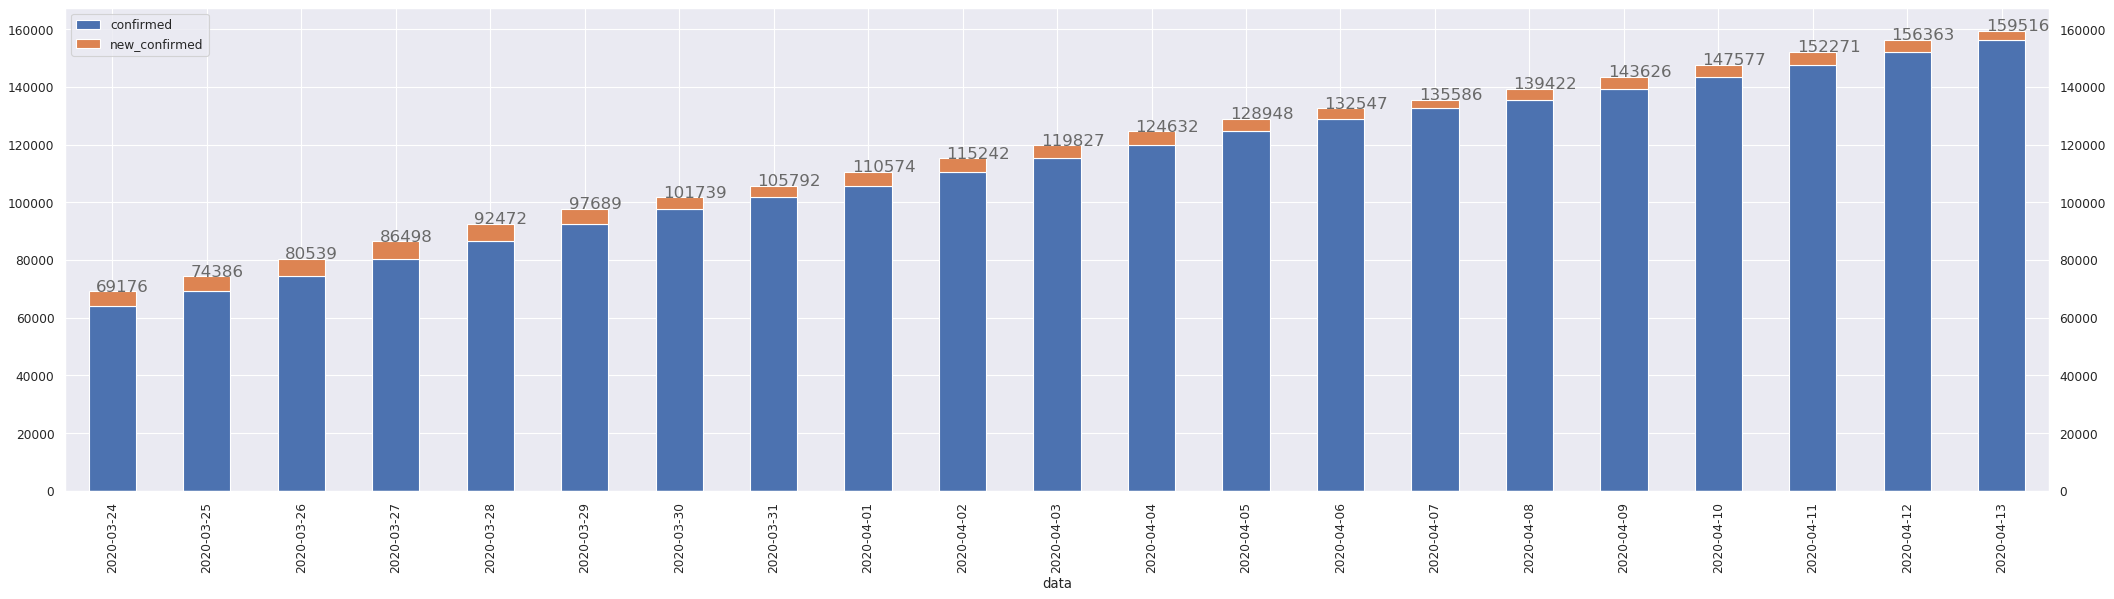

In [36]:
cbr_italy.plot_daily_stacked()

In [37]:
cbr_spain = covid19.CasesByRegion('Spain')
cbr_spain.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-04-09,153222,52165,15447,5002,4144,655
2020-04-10,158273,55668,16081,5051,3503,634
2020-04-11,163027,59109,16606,4754,3441,525
2020-04-12,166831,62391,17209,3804,3282,603
2020-04-13,170099,64727,17756,3268,2336,547


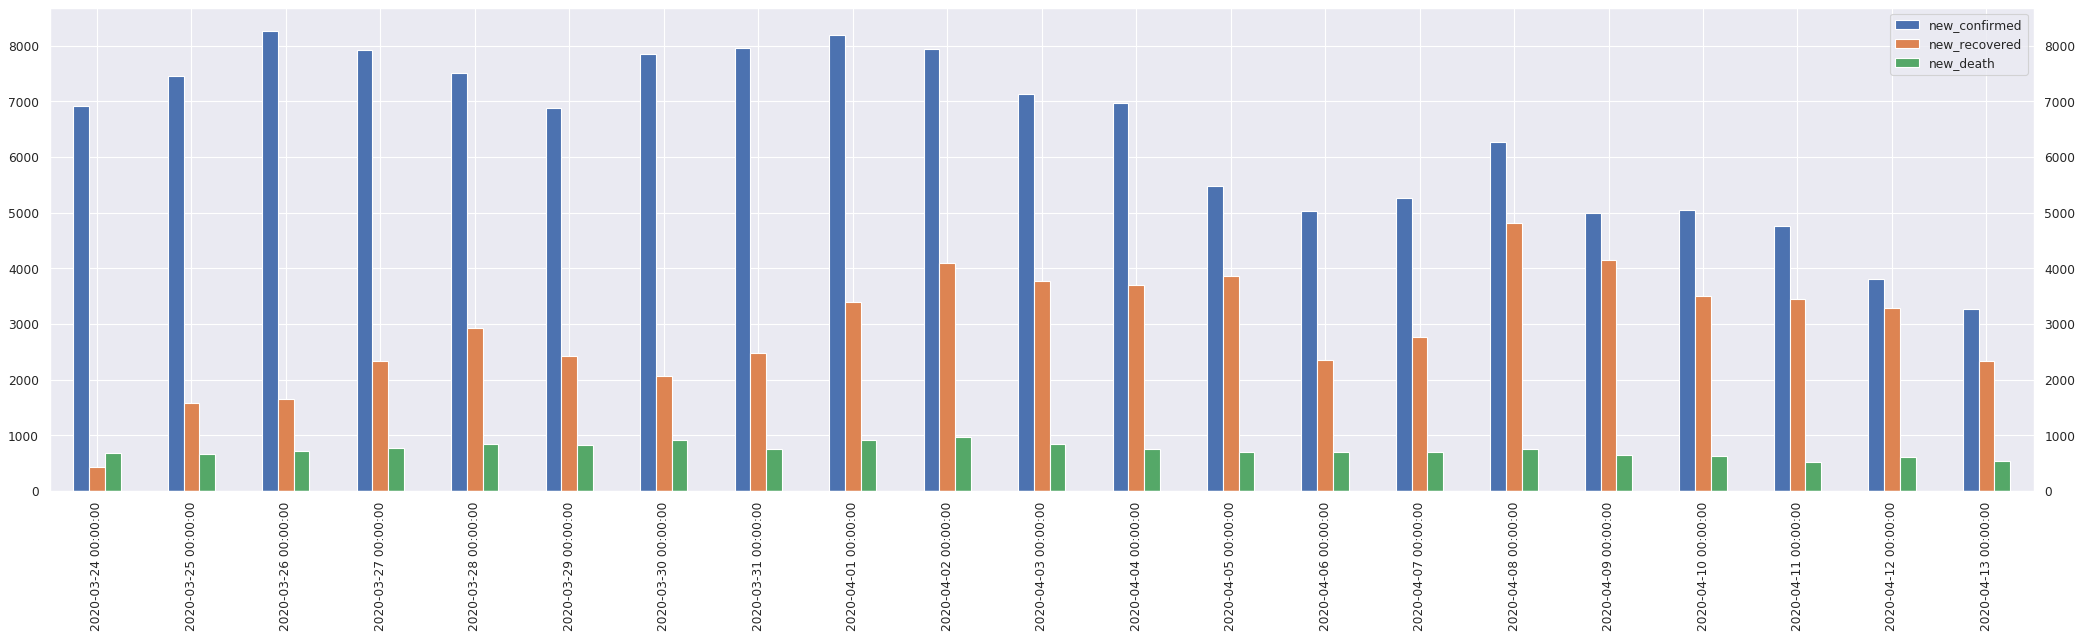

In [38]:
cbr_spain.plot_daily_stats()

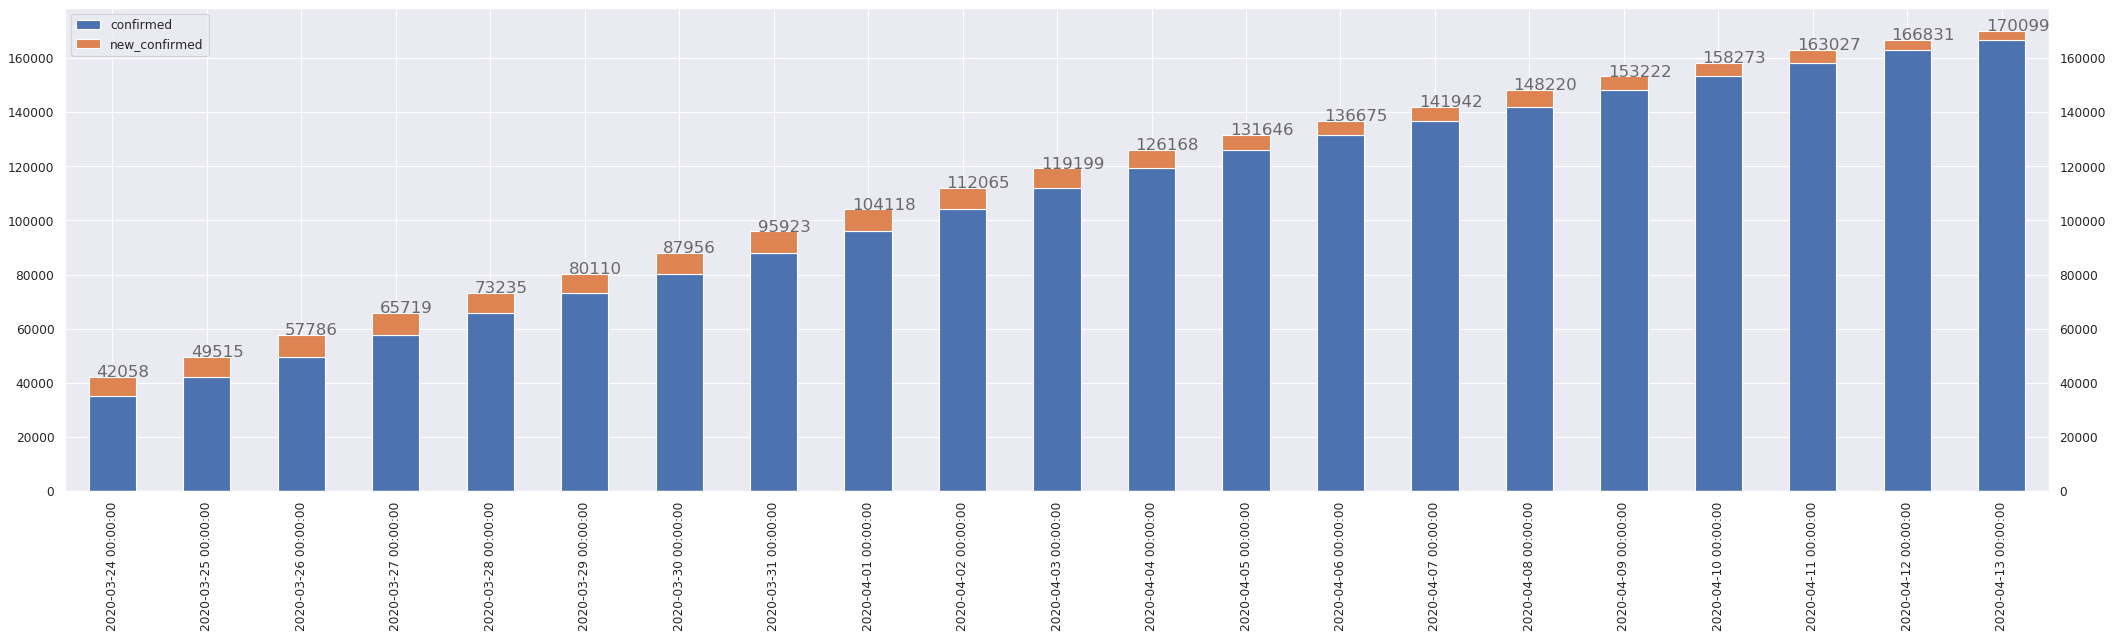

In [39]:
cbr_spain.plot_daily_stacked()

In [40]:
cbr_france = covid19.CasesByRegion('France')
cbr_france.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-04-09,118781,23413,12228,4822,1961,1341
2020-04-10,125931,25195,13215,7150,1782,987
2020-04-11,130727,26663,13851,4796,1468,636
2020-04-12,133670,27469,14412,2943,806,561
2020-04-13,137875,28001,14986,4205,532,574


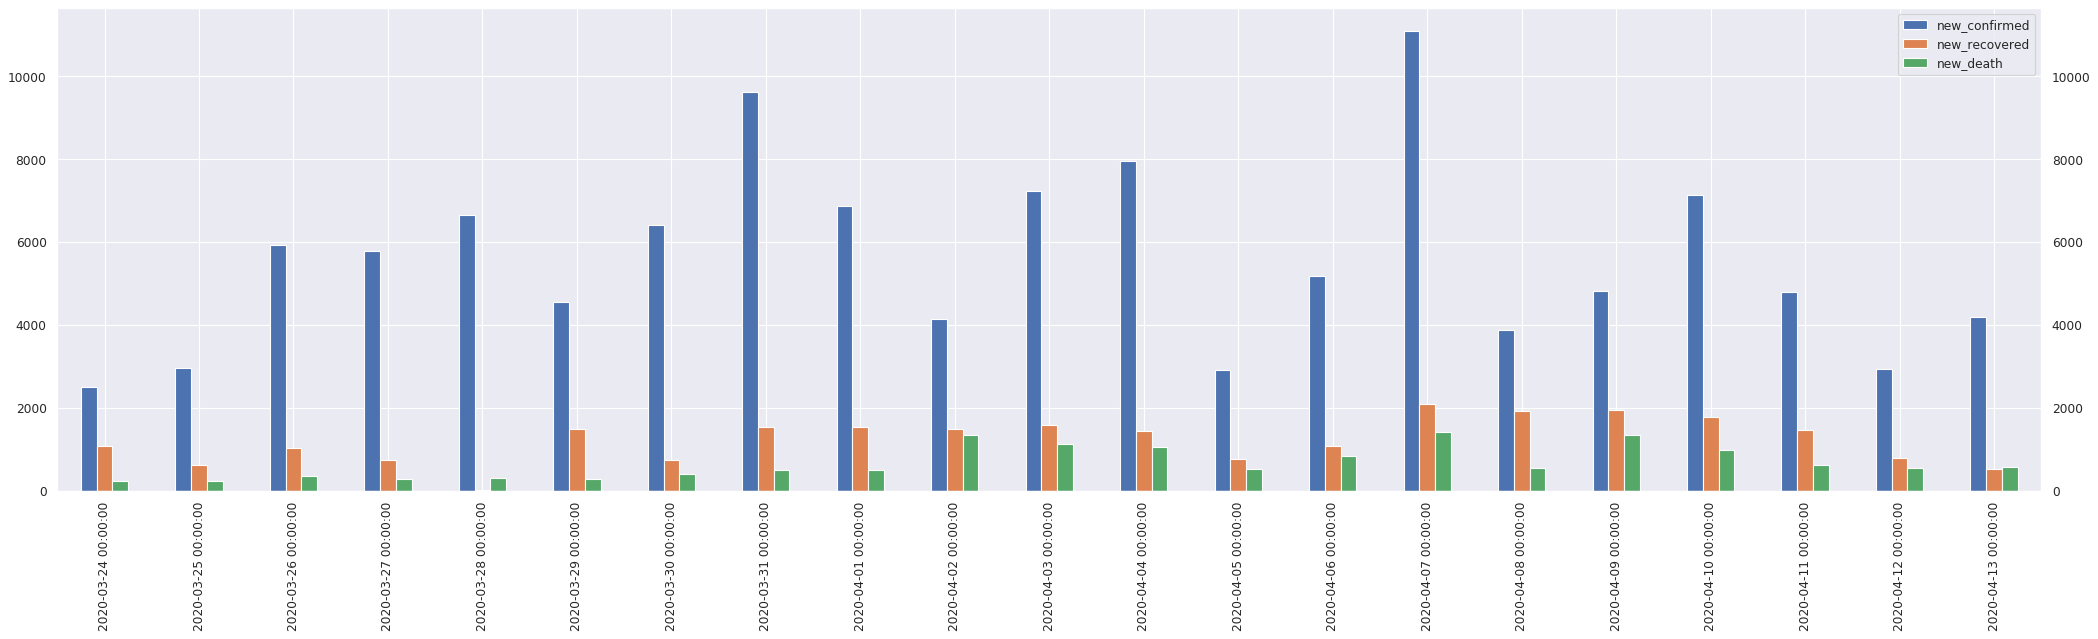

In [41]:
cbr_france.plot_daily_stats()

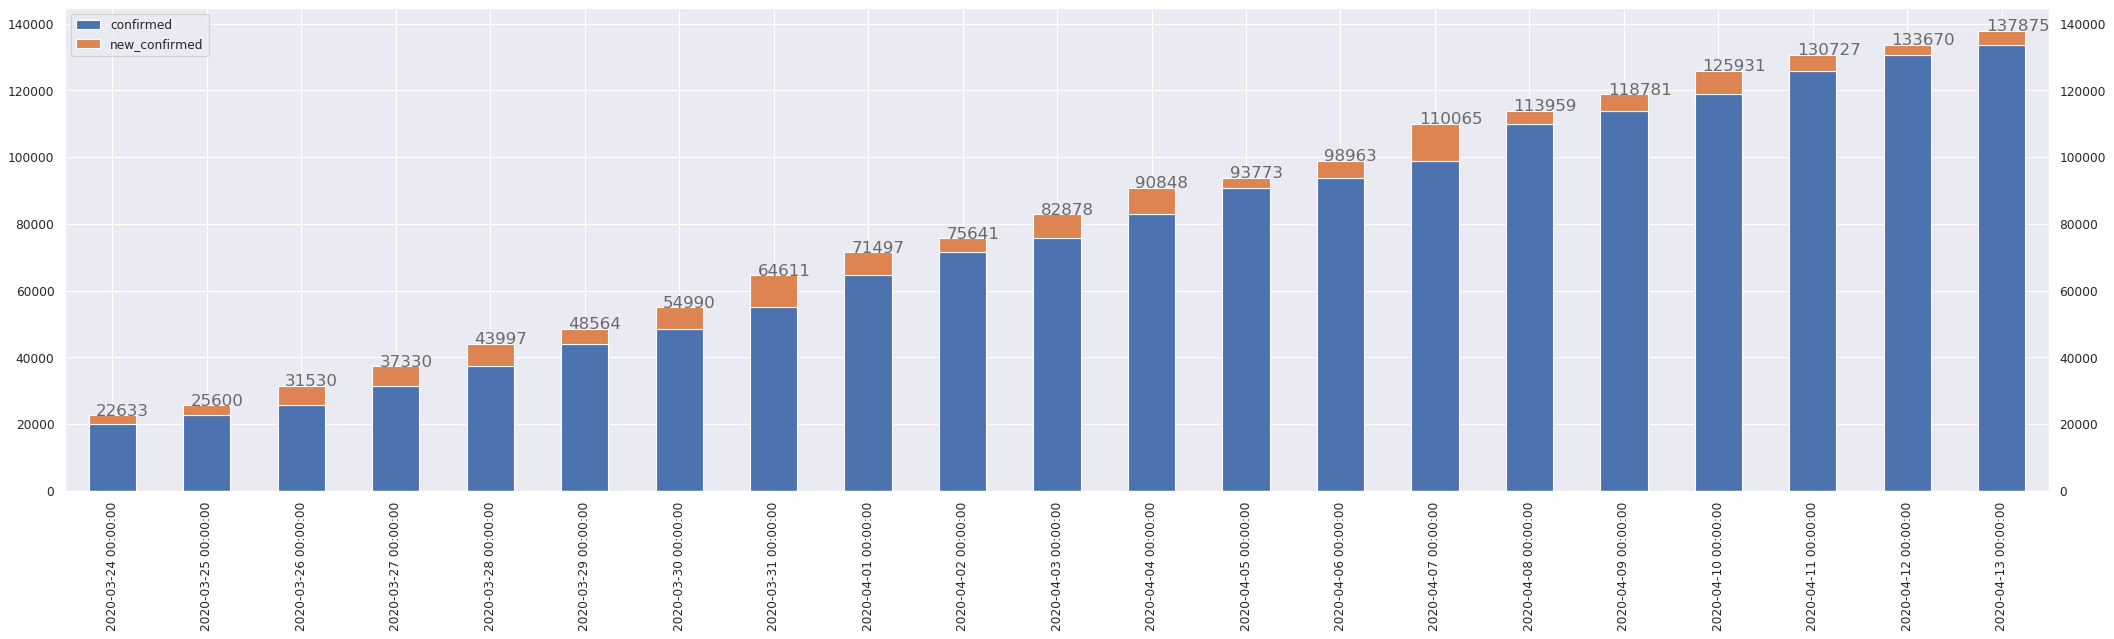

In [42]:
cbr_france.plot_daily_stacked()

In [43]:
cbr_south_korea = covid19.CasesByRegion('Korea, South')
cbr_south_korea.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-04-09,10423,6973,204,39,197,4
2020-04-10,10450,7117,208,27,144,4
2020-04-11,10480,7243,211,30,126,3
2020-04-12,10512,7368,214,32,125,3
2020-04-13,10537,7447,217,25,79,3


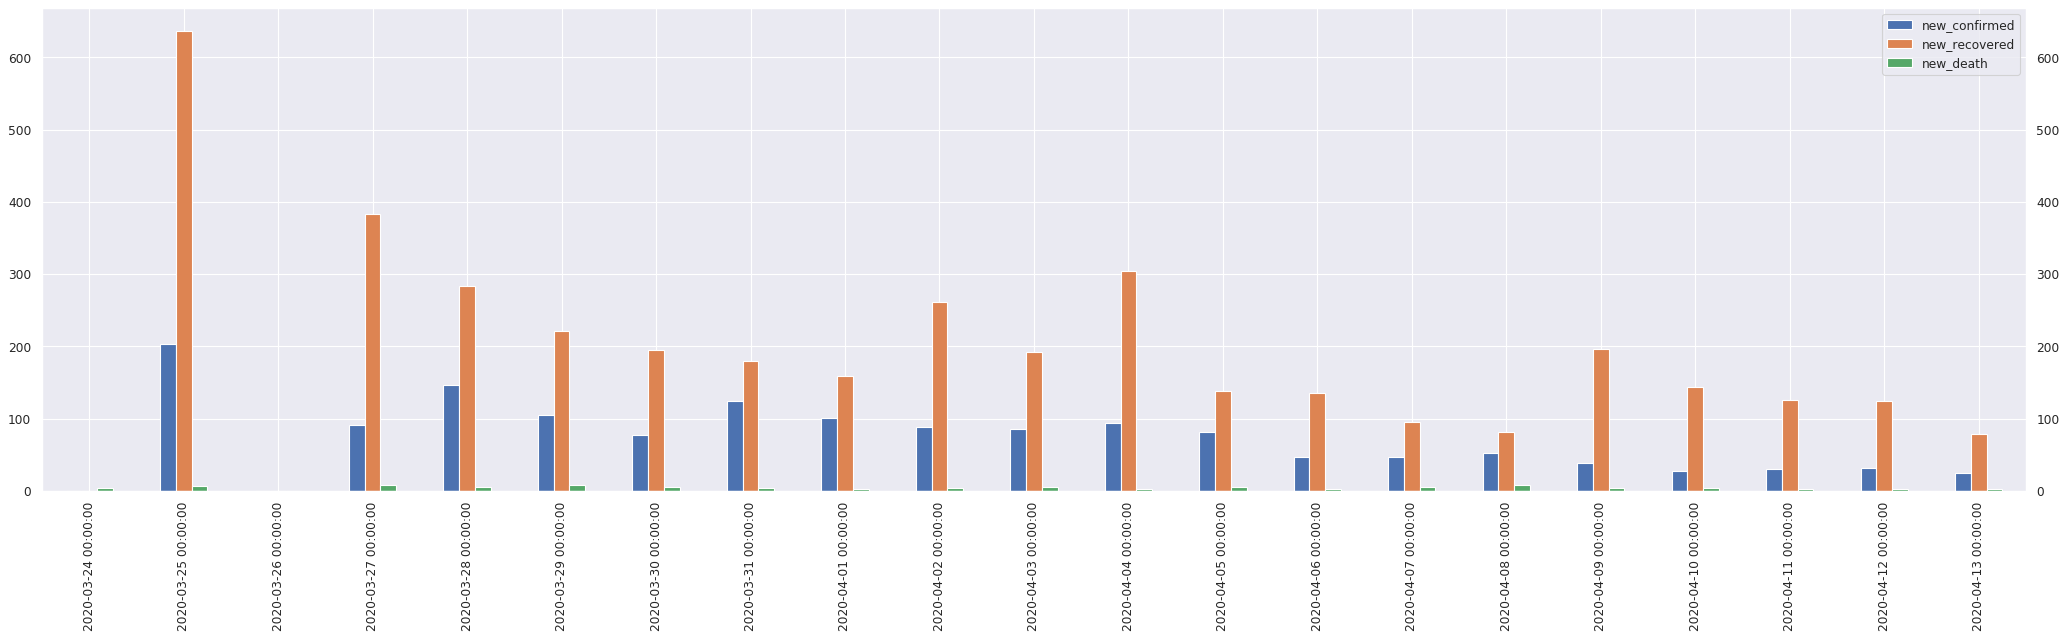

In [44]:
cbr_south_korea.plot_daily_stats()

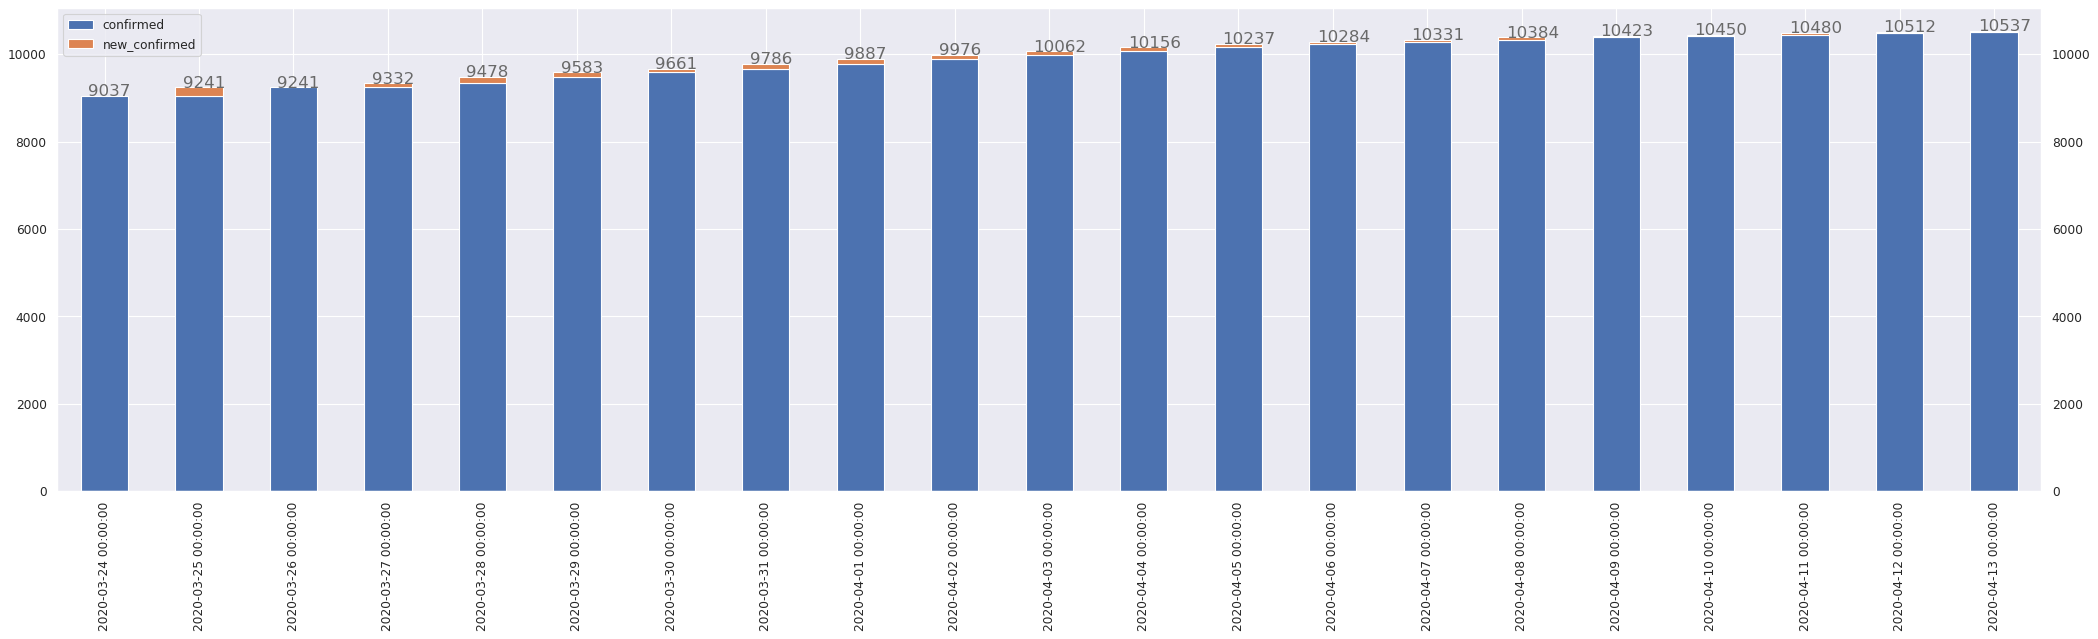

In [45]:
cbr_south_korea.plot_daily_stacked()

In [46]:
cbr_uk = covid19.CasesByRegion('United Kingdom')
cbr_uk.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-04-09,65872,359,7993,4398,14,882
2020-04-10,74605,588,8974,8733,229,981
2020-04-11,79874,622,9892,5269,34,918
2020-04-12,85206,626,10629,5332,4,737
2020-04-13,89570,304,11347,4364,-322,718


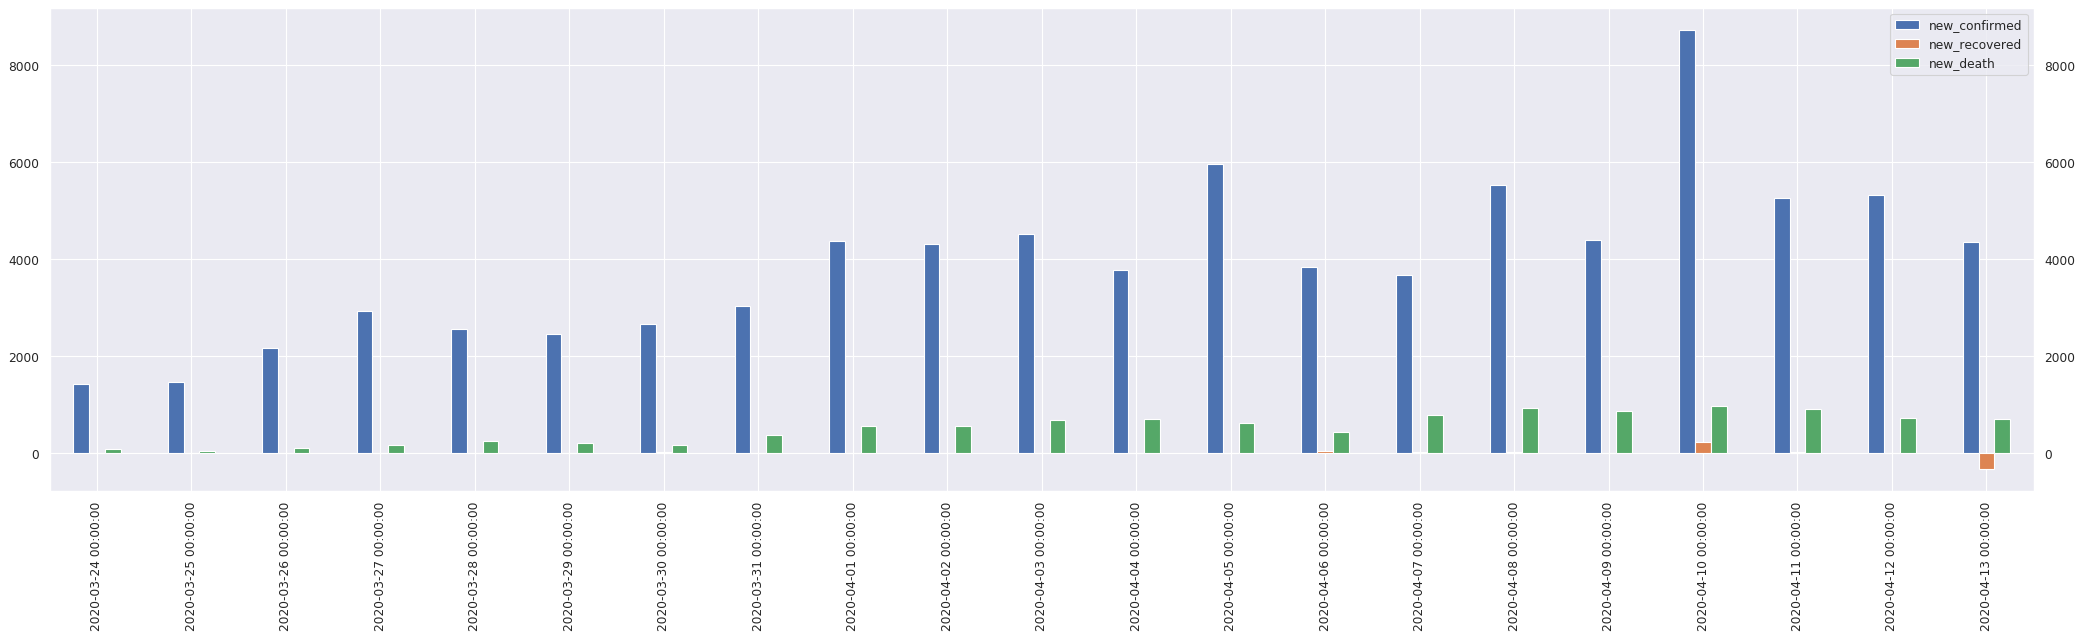

In [47]:
cbr_uk.plot_daily_stats()

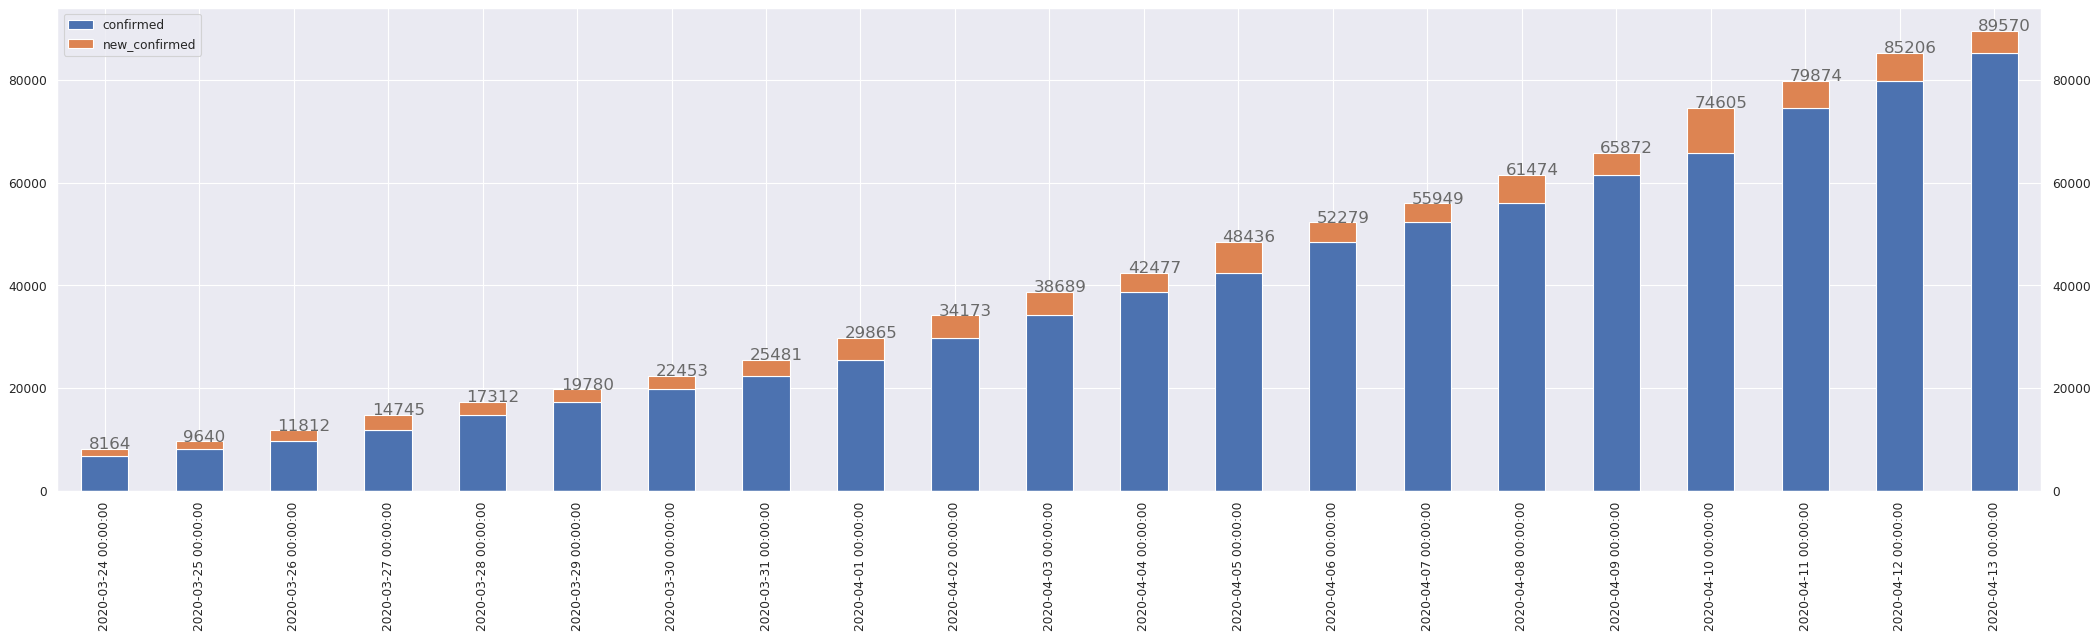

In [48]:
cbr_uk.plot_daily_stacked()

In [49]:
cbr_us = covid19.CasesByRegion('US')
cbr_us.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-04-09,461437,25410,16478,32385,1851,1783
2020-04-10,496535,28790,18586,35098,3380,2108
2020-04-11,526396,31270,20463,29861,2480,1877
2020-04-12,555313,32988,22020,28917,1718,1557
2020-04-13,580619,43482,23529,25306,10494,1509


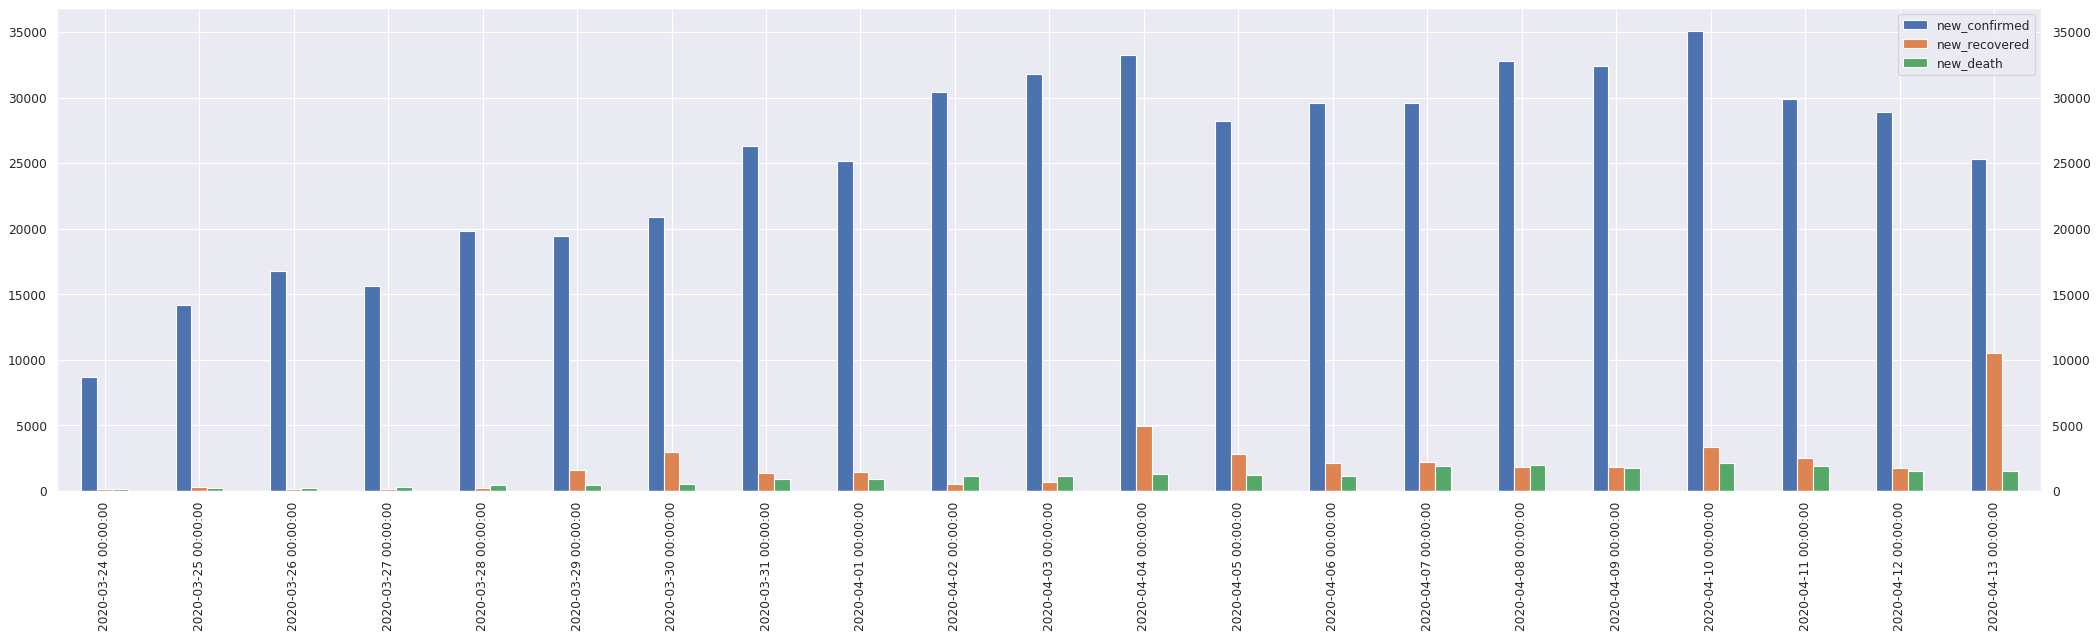

In [50]:
cbr_us.plot_daily_stats()

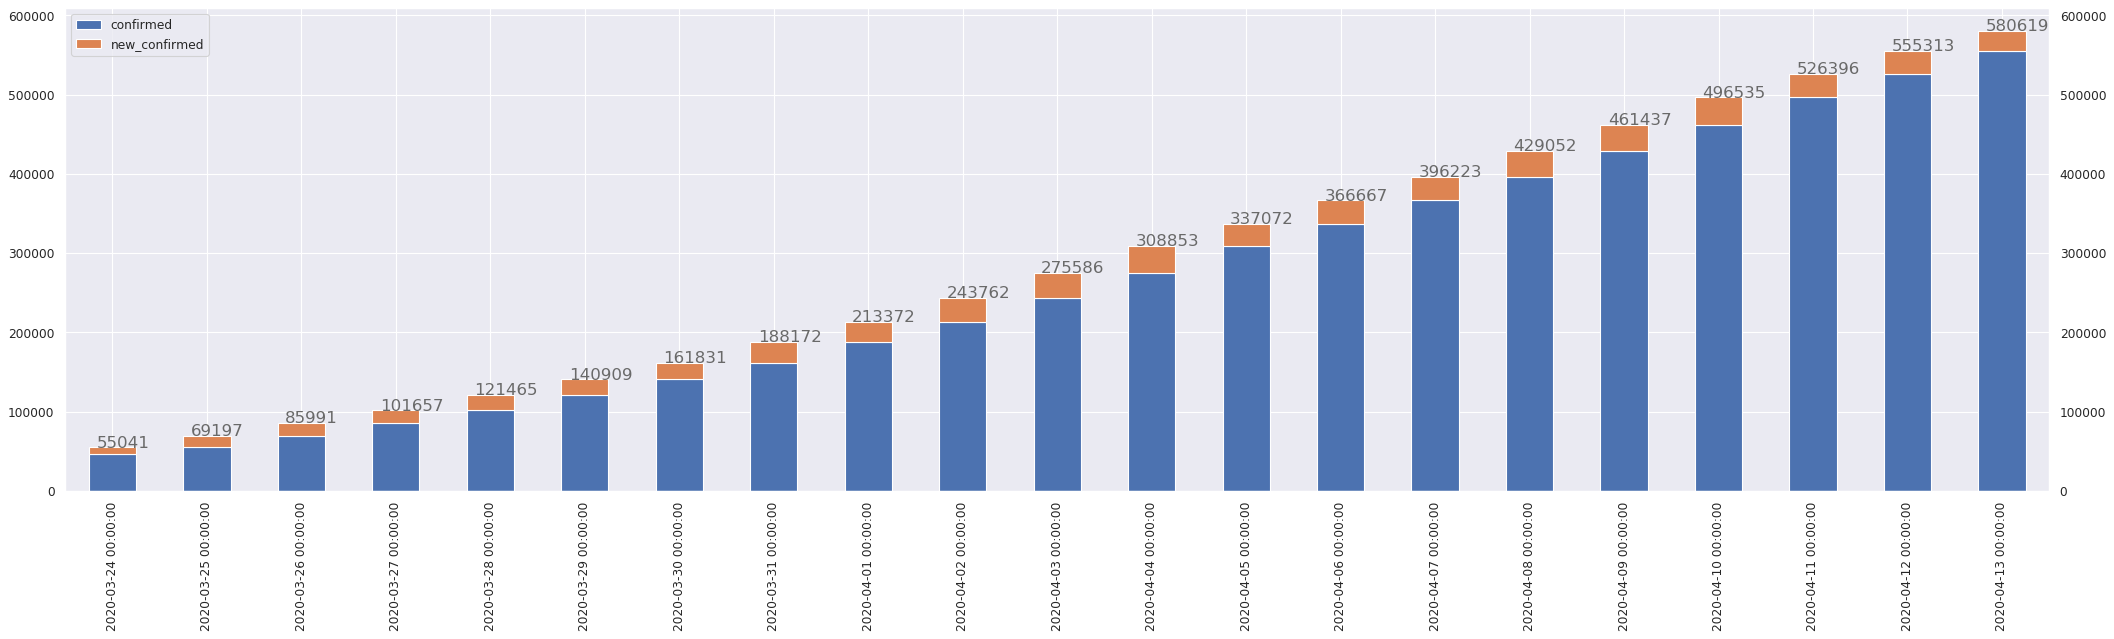

In [51]:
cbr_us.plot_daily_stacked()

In [52]:
cbr_switzerland = covid19.CasesByRegion('Switzerland')
cbr_switzerland.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-04-09,24051,10600,948,771,800,53
2020-04-10,24551,11100,1002,500,500,54
2020-04-11,25107,12100,1036,556,1000,34
2020-04-12,25415,12700,1106,308,600,70
2020-04-13,25688,13700,1138,273,1000,32


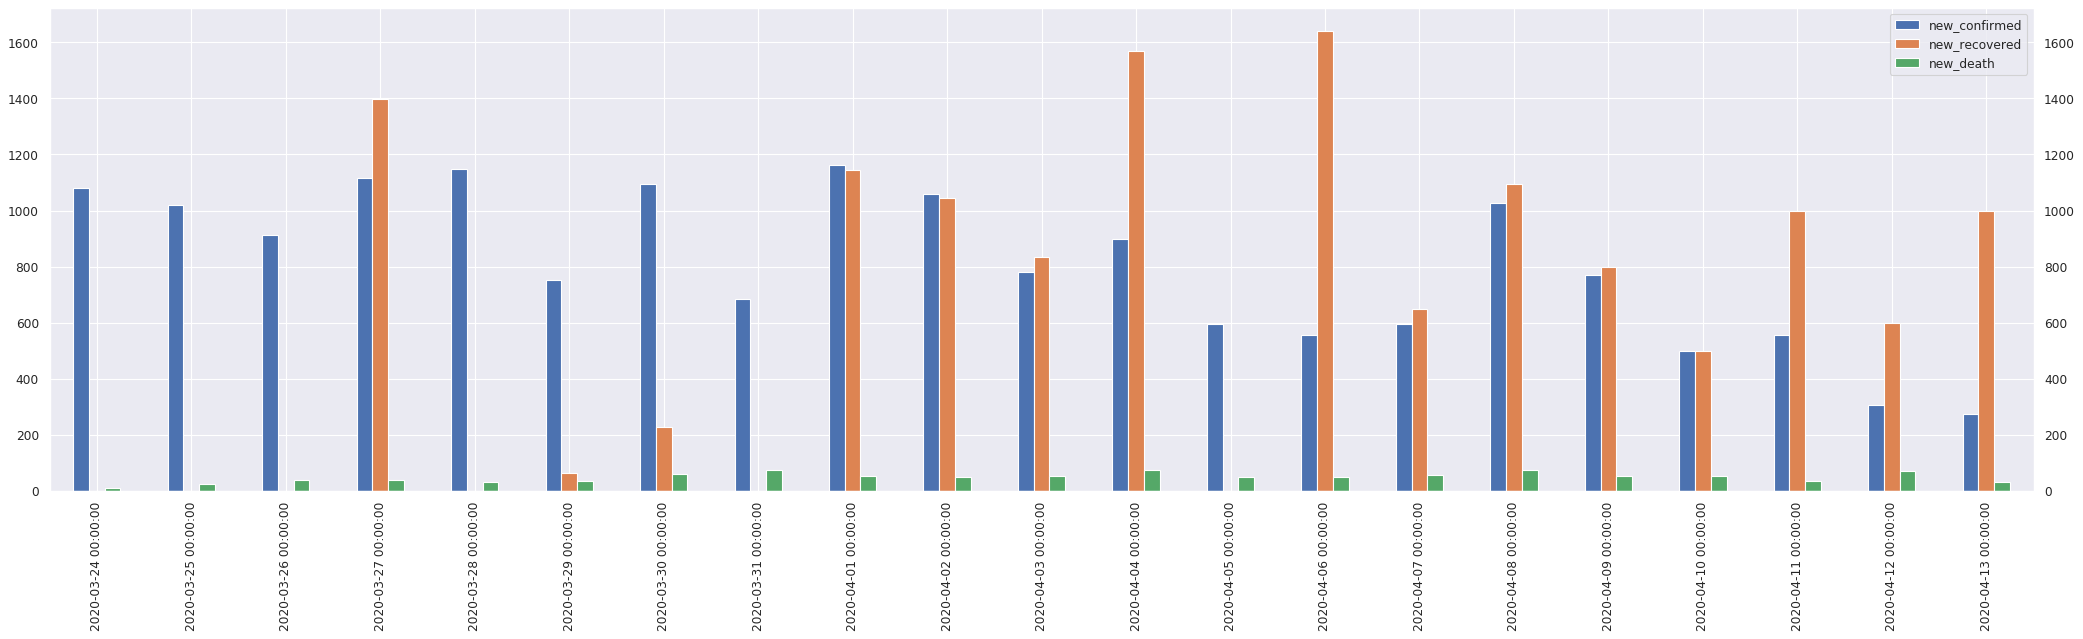

In [53]:
cbr_switzerland.plot_daily_stats()

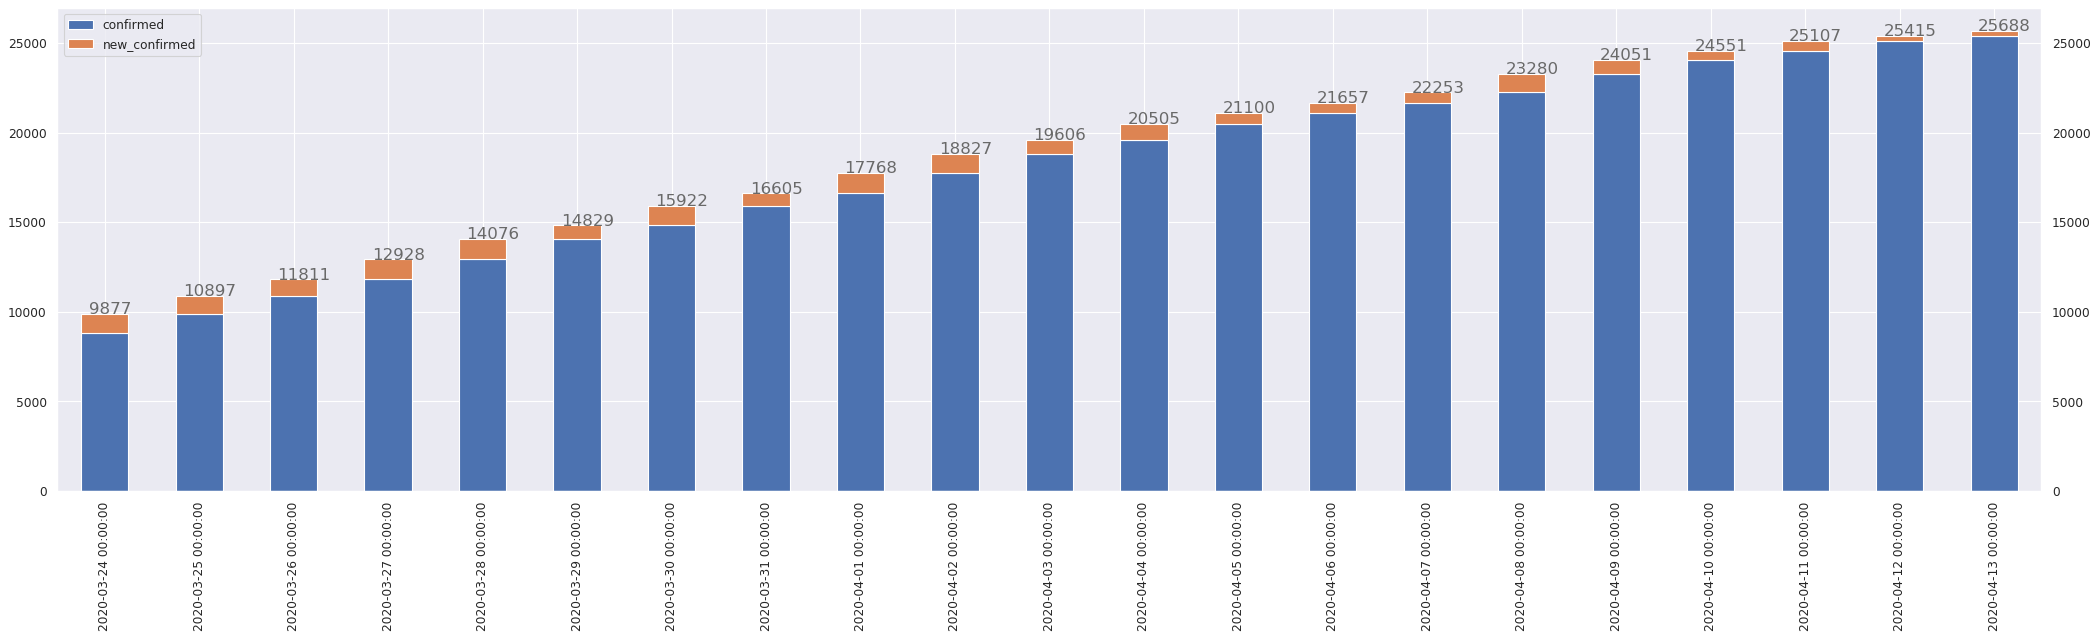

In [54]:
cbr_switzerland.plot_daily_stacked()

In [55]:
df_co = covid19.get_country_overview()
df_co.head()

,confirmed,recovered,death,death_rate,death_rate_
Country/Region_2020-04-13,,,,,
MS Zaandam,9,0,2,22.222222,66.666667
Burundi,5,0,1,20.000000,50.000000
Zimbabwe,17,0,3,17.647059,75.000000
Bahamas,47,6,8,17.021277,53.333333
Algeria,1983,601,313,15.784165,34.207650


In [56]:
df_co[df_co.confirmed > 2000].round(1)

,confirmed,recovered,death,death_rate,death_rate_
Country/Region_2020-04-13,,,,,
Italy,159516,35435,20465,12.8,36.6
Belgium,30589,6707,3903,12.8,36.8
United Kingdom,89570,304,11347,12.7,97.4
France,137875,28001,14986,10.9,34.9
Netherlands,26710,295,2833,10.6,90.5
Spain,170099,64727,17756,10.4,21.5
Indonesia,4557,380,399,8.8,51.2
Sweden,10948,381,919,8.4,70.6
Egypt,2190,589,164,7.5,21.8
